In [44]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTE
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.preprocessing import MaxAbsScaler
from sklearn.linear_model import SGDClassifier
import shap
from sklearn.metrics import accuracy_score
import pickle
import json

## Reading the data

In [45]:
data_df_100 = pd.read_csv('../data/data_100.csv')
data_df_90 = pd.read_csv('../data/data_90.csv')
data_df_80 = pd.read_csv('../data/data_80.csv')
data_df_70 = pd.read_csv('../data/data_70.csv')
data_df_60 = pd.read_csv('../data/data_60.csv')
data_df_50 = pd.read_csv('../data/data_50.csv')
data_df_40 = pd.read_csv('../data/data_40.csv')

In [46]:
rest_data_df_100 = pd.read_csv('../data/data_with_rest/data_100.csv')
rest_data_df_90 = pd.read_csv('../data/data_with_rest/data_90.csv')
rest_data_df_80 = pd.read_csv('../data/data_with_rest/data_80.csv')
rest_data_df_70 = pd.read_csv('../data/data_with_rest/data_70.csv')
rest_data_df_60 = pd.read_csv('../data/data_with_rest/data_60.csv')
rest_data_df_50 = pd.read_csv('../data/data_with_rest/data_50.csv')
rest_data_df_40 = pd.read_csv('../data/data_with_rest/data_40.csv')

In [47]:
print(f"100%: #rows with rest {rest_data_df_100.shape[0]}, without rest{data_df_100.shape[0]}")
print(f"90%: #rows with rest {rest_data_df_90.shape[0]}, without rest{data_df_90.shape[0]}")
print(f"80%: #rows with rest {rest_data_df_80.shape[0]}, without rest{data_df_80.shape[0]}")
print(f"70%: #rows with rest {rest_data_df_70.shape[0]}, without rest{data_df_70.shape[0]}")
print(f"60%: #rows with rest {rest_data_df_60.shape[0]}, without rest{data_df_60.shape[0]}")
print(f"50%: #rows with rest {rest_data_df_50.shape[0]}, without rest{data_df_50.shape[0]}")
print(f"40%: #rows with rest {rest_data_df_40.shape[0]}, without rest{data_df_40.shape[0]}")

100%: #rows with rest 217, without rest217
90%: #rows with rest 219, without rest217
80%: #rows with rest 219, without rest217
70%: #rows with rest 219, without rest217
60%: #rows with rest 219, without rest217
50%: #rows with rest 219, without rest217
40%: #rows with rest 219, without rest217


## The functions

In [5]:
def evaluate_model(classifier, X, y, scaler, train_size=0.8, total_samples=100, smote=False, best_model=False, best_criteria='positives'):
    """
    if smote is True:
        oversample = SMOTE()
        X, y = oversample.fit_resample(X, y)
    """
    oversample = SMOTE()
    auc_vals = np.array([])
    acc_vals = np.array([])
    specificity_vals = np.array([])
    sensitivity_vals = np.array([])
    ppv_vals = np.array([])
    model_list = []
    scaler_list = []
    proba_vals = []
    test_vals = []
    fpr_vals = []
    tpr_vals = []
    for i in range(1,total_samples):
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size)
        if smote is True:
            X_train, y_train = oversample.fit_resample(X_train, y_train)
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
        clf = classifier
        model = clf.fit(X_train,y_train)
        model_list.append(model)
        scaler_list.append(scaler)
        y_hat = model.predict_proba(X_test)
        proba_vals.append(y_hat[:,1])
        test_vals.append(y_test)
        if np.sum(np.round(y_hat[:,1])) == 0:
            continue
        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_hat[:,1])
        tn, fp, fn, tp = confusion_matrix(y_test,np.round(y_hat[:,1])).ravel()
        specificity = tn / (tn+fp)
        sensitivity = tp / (tp+fn)
        ppv = tp/(tp+fp)
        auc_vals = np.append(metrics.auc(fpr, tpr),auc_vals)
        acc_vals = np.append(accuracy_score(y_test, np.round(y_hat[:,1])),acc_vals)
        specificity_vals = np.append(specificity,specificity_vals)
        sensitivity_vals = np.append(sensitivity,sensitivity_vals)
        ppv_vals = np.append(ppv,ppv_vals)
        fpr_vals.append(fpr)
        tpr_vals.append(tpr)
        pass
    print('AUC: {:.3f} +- {:.3f}'.format(np.mean(auc_vals), np.std(auc_vals)))
    print('Sensitivity: {:.3f} +- {:.3f}'.format(np.mean(sensitivity_vals), np.std(sensitivity_vals)))
    print('Specificity: {:.3f} +- {:.3f}'.format(np.mean(specificity_vals), np.std(specificity_vals)))
    print('Positive Predictive Values: {:.3f} +- {:.3f}'.format(np.mean(ppv_vals), np.std(ppv_vals)))
    print('Accuracy: {:.3f} +- {:.3f}'.format(np.mean(acc_vals), np.std(acc_vals)))
    if best_model is True:
        max_ppv_index = 0
        if best_criteria == 'positives':
            best_vals = ppv_vals*2.5 + sensitivity_vals*2
            max_ppv_index = np.argmax(best_vals)
        elif best_criteria == 'auc':
            max_ppv_index = np.argmax(auc_vals)
        elif best_criteria == 'accuracy_ppv':
            best_vals = ppv_vals*2.5 + auc_vals*2
            max_ppv_index = np.argmax(best_vals)
        else:
            max_ppv_index = np.argmax(acc_vals)
        print(max_ppv_index)
        print('The highest ppv model has the following:')
        print('AUC: {:.3f}'.format(auc_vals[max_ppv_index]))
        print('Sensitivity: {:.3f}'.format(sensitivity_vals[max_ppv_index]))
        print('Specificity: {:.3f}'.format(specificity_vals[max_ppv_index]))
        print('Positive Predictive Values: {:.3f}'.format(ppv_vals[max_ppv_index]))
        print('Accuracy: {:.3f}'.format(acc_vals[max_ppv_index]))
        
        return model_list[max_ppv_index],proba_vals,test_vals,fpr_vals[max_ppv_index],tpr_vals[max_ppv_index], scaler_list[max_ppv_index]
    pass

In [6]:
def evaluate_model_alt(classifier, X, y, scaler, train_size=0.8, total_samples=100, smote=False, best_model=False, best_criteria='positives'):
    """
    if smote is True:
        oversample = SMOTE()
        X, y = oversample.fit_resample(X, y)
    """
    oversample = SMOTE()
    auc_vals = np.array([])
    acc_vals = np.array([])
    specificity_vals = np.array([])
    sensitivity_vals = np.array([])
    ppv_vals = np.array([])
    model_list = []
    scaler_list = []
    proba_vals = []
    test_vals = []
    fpr_vals = []
    tpr_vals = []
    for i in range(1,total_samples):
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size)
        scaler.fit(X_train)
        if smote is True:
            X_train, y_train = oversample.fit_resample(X_train, y_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
        clf = classifier
        model = clf.fit(X_train,y_train)
        model_list.append(model)
        scaler_list.append(scaler)
        y_hat = model.predict_proba(X_test)
        proba_vals.append(y_hat[:,1])
        test_vals.append(y_test)
        if np.sum(np.round(y_hat[:,1])) == 0:
            continue
        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_hat[:,1])
        tn, fp, fn, tp = confusion_matrix(y_test,np.round(y_hat[:,1])).ravel()
        specificity = tn / (tn+fp)
        sensitivity = tp / (tp+fn)
        ppv = tp/(tp+fp)
        auc_vals = np.append(metrics.auc(fpr, tpr),auc_vals)
        acc_vals = np.append(accuracy_score(y_test, np.round(y_hat[:,1])),acc_vals)
        specificity_vals = np.append(specificity,specificity_vals)
        sensitivity_vals = np.append(sensitivity,sensitivity_vals)
        ppv_vals = np.append(ppv,ppv_vals)
        fpr_vals.append(fpr)
        tpr_vals.append(tpr)
        pass
    print('AUC: {:.3f} +- {:.3f}'.format(np.mean(auc_vals), np.std(auc_vals)))
    print('Sensitivity: {:.3f} +- {:.3f}'.format(np.mean(sensitivity_vals), np.std(sensitivity_vals)))
    print('Specificity: {:.3f} +- {:.3f}'.format(np.mean(specificity_vals), np.std(specificity_vals)))
    print('Positive Predictive Values: {:.3f} +- {:.3f}'.format(np.mean(ppv_vals), np.std(ppv_vals)))
    print('Accuracy: {:.3f} +- {:.3f}'.format(np.mean(acc_vals), np.std(acc_vals)))
    if best_model is True:
        max_ppv_index = 0
        if best_criteria == 'positives':
            best_vals = ppv_vals*2.5 + sensitivity_vals*2
            max_ppv_index = np.argmax(best_vals)
        elif best_criteria == 'auc':
            max_ppv_index = np.argmax(auc_vals)
        elif best_criteria == 'accuracy_ppv':
            best_vals = ppv_vals*2.5 + auc_vals*2
            max_ppv_index = np.argmax(best_vals)
        else:
            max_ppv_index = np.argmax(acc_vals)
        print(max_ppv_index)
        print('The highest ppv model has the following:')
        print('AUC: {:.3f}'.format(auc_vals[max_ppv_index]))
        print('Sensitivity: {:.3f}'.format(sensitivity_vals[max_ppv_index]))
        print('Specificity: {:.3f}'.format(specificity_vals[max_ppv_index]))
        print('Positive Predictive Values: {:.3f}'.format(ppv_vals[max_ppv_index]))
        print('Accuracy: {:.3f}'.format(acc_vals[max_ppv_index]))
        
        return model_list[max_ppv_index],proba_vals,test_vals,fpr_vals[max_ppv_index],tpr_vals[max_ppv_index], scaler_list[max_ppv_index], model_list, scaler_list
    pass

In [7]:
def interpret_model(model, data_df, features,label):
    modelLimitation = model.fit(data_df[features],data_df[label])
    explainer = shap.TreeExplainer(modelLimitation, data=data_df[features])
    shap_values = explainer.shap_values(data_df[features])
    shap.summary_plot(shap_values[1], data_df[features], plot_type='dot', max_display=data_df.shape[1])
    pass

In [8]:
def get_waterfall_plot(model, data_df, features,label):
    modelLimitation = model.fit(data_df[features],data_df[label])
    explainer = shap.TreeExplainer(modelLimitation, data=data_df[features])
    shap_values = explainer.waterfall_plot(data_df[features])
    shap.summary_plot(shap_values[1], data_df[features], plot_type='dot', max_display=data_df.shape[1])
    pass

In [9]:
def explain_model(model, df_data, features, ravel=False):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(df_data[features])
    if ravel is True:
        for feature in features:
            shap.dependence_plot(feature, shap_values[1], df_data[features], show=False, interaction_index=None)
    else:
        fig, axes = plt.subplots(nrows=int(np.ceil(len(features)/4)), ncols=4, figsize=(20, 14))
        axes = axes.ravel()
        for i, col in enumerate(features):
            shap.dependence_plot(col, shap_values[1], df_data[features], ax=axes[i], show=False, interaction_index=None)

In [10]:
def save_model(model, scaler, name):
    filename = name + '.sav'
    pickle.dump(model, open(filename,'wb'))
    filename = 'scaler_' + name + '.sav'
    pickle.dump(scaler, open(filename,'wb'))

## Working with the cardiac data

In [17]:
# rest_cardiac_data_100 = ['CardiacLim','DiffPercentPeakVO2', 'DiffPeakVO2','75_to_100_VO2Slope','75_to_100_HRSlope','MinO2Pulse',
#                       'PeakVE','VO2vsPeakVO2atVT','second_half_RRSlope','second_half_VO2Slope','75_to_100_VCO2Slope','MeanVE',
#                       'second_half_VESlope','O2PulseDiff','50_to_75_O2Slope',
#                         'O2PulsePercent','75_to_100_RERSlope','PeakRER','50_to_75_VO2Slope','PeakVO2Real']
rest_cardiac_data_100 = ['CardiacLim','DiffPercentPeakVO2','DiffPeakVO2','75_to_100_VO2Slope','MinO2Pulse','75_to_100_HRSlope','PeakVE','15_to_85_VESlope',
                  '75_to_100_VCO2Slope', 'second_half_RRSlope','MeanVE','O2PulseDiff','second_half_VO2Slope','second_half_VESlope','75_to_100_RERSlope',
                  'second_half_RERSlope','VO2vsPeakVO2atVT','75_to_100_VESlope','MeanVO2','MeanO2Pulse','second_half_VCO2Slope','first_half_VEVCO2Slope']
rest_cardiac_data_90 = ['CardiacLim','DiffPercentPeakVO2','DiffPeakVO2','MinO2Pulse','second_half_VEVO2Slope',
                '25_to_50_VCO2Slope','VO2vsPeakVO2atVT','PeakVE','15_to_85_VO2Slope','first_half_VEVCO2Slope',
                '25_to_50_VO2Slope','MeanVO2','25_to_50_VESlope','PeakVO2Real','PeakVO2', '15_to_85_VESlope',
                   'second_half_RRSlope','PeakRER','second_half_VCO2Slope','O2PulsePercent','15_to_85_VCO2Slope',
                   '75_to_100_VESlope','MeanVE','first_half_VO2Slope','second_half_VESlope','first_half_VEVO2Slope',
                   '75_to_100_HRSlope','DiffPercentPeakHR','15_to_85_HRSlope']
rest_cardiac_data_80 = ['CardiacLim','DiffPercentPeakVO2','DiffPeakVO2','first_half_VEVCO2Slope','MinO2Pulse','15_to_85_VO2Slope',
                   '25_to_50_VEVCO2Slope','MeanVO2','PeakVO2Real','PeakVO2','MeanHeartRate','first_half_VO2Slope',
                  'first_half_VEVO2Slope','O2PulsePercent','StdHeartRate','second_half_VEVO2Slope','75_to_100_RRSlope',
                  'DiffPeakHR','PredictedMaxHR']
rest_cardiac_data_70 = ['CardiacLim','DiffPercentPeakVO2','15_to_85_VO2Slope','PeakVO2Real','DiffPeakVO2','MinO2Pulse','PeakVO2',
                   'first_half_VEVCO2Slope','MeanVO2','15_to_85_VCO2Slope','PeakVCO2','StdO2Pulse','PredictedMaxHR',
                   '15_to_85_VESlope','MeanVCO2']
rest_cardiac_data_60 = ['CardiacLim','50_to_75_VO2Slope','50_to_75_VCO2Slope','DiffPercentPeakVO2','15_to_85_VO2Slope','StdO2Pulse',
                  '50_to_75_VESlope','first_half_VEVCO2Slope','PeakVO2','MinO2Pulse','PeakVO2Real','O2PulsePercent',
                  'MeanVO2','StdHeartRate','LowestVE/VCO2','VEvsVCO2Slope','50_to_75_HRSlope',
                  '15_to_85_VEVO2Slope']
rest_cardiac_data_50 = ['CardiacLim','StdO2Pulse','15_to_85_VEVCO2Slope','DiffPercentPeakVO2','second_half_VCO2Slope',
                'MeanVE/VCO2','second_half_VO2Slope','second_half_VESlope','PeakVO2Real','MinO2Pulse','PeakVO2','O2PulseDiff',
                'StdHeartRate','15_to_85_VEVO2Slope','VEvsVCO2Slope','second_half_HRSlope']
rest_cardiac_data_40 = ['CardiacLim','StdO2Pulse','DiffPercentPeakVO2','second_half_VEVCO2Slope','MinO2Pulse','O2PulseDiff',
                   'PeakVO2','PeakVO2Real','O2PulsePercent','VEvsVCO2Slope','MaxO2Pulse','LowestVE/VCO2','MeanVE/VCO2',
                  'second_half_VEVO2Slope','second_half_HRSlope','second_half_VCO2Slope','PeakVCO2','StdVE/VCO2']

In [18]:
cardiac_feature_dict = {
  "DiffPercentPeakVO2": "Actual/Expected Peak VO2",
  "DiffPeakVO2": "Actual - Expected Peak VO2",
  "75_to_100_VO2Slope": "Session's last quarter VO2 slope",
  "75_to_100_HRSlope": "Session's last quarter HR slope",
  "MinO2Pulse": "Minimum O2 pulse",
  "PeakVE": "Max minute ventilation",
  "VO2vsPeakVO2atVT": "VO2 at ventilatory threshold vs expected VO2",
  "second_half_RRSlope": "Second half Respiratory Rate slope",
  "second_half_VO2Slope": "Second half VO2 slope",
  "75_to_100_VCO2Slope": "Last quarter VCO2 slope",
  "MeanVE": "Mean minute ventilation",
  "second_half_VESlope": "Second half VE slope",
  "O2PulseDiff": "Actual - Expected maximum O2 pulse",
  "50_to_75_O2Slope": "Third quarter O2 pulse",
  "O2PulsePercent": "Actual/Expected maximum O2 pulse",
  "75_to_100_RERSlope": "Last quarter RER slope",
  "PeakRER": "Max RER",
  "50_to_75_VO2Slope": "Last quarter VO2 slope",
  "PeakVO2Real": "Max VO2",
  "15_to_85_VESlope": "Session's 85 to 15% VE Slope",
  "second_half_RERSlope":"Second half Respiratory Exchange Ratio slope",
  "75_to_100_VESlope":"Last quarter minute ventilation slope",
  "MeanVO2":"Overall mean VO2",
  "MeanO2Pulse":"Mean O2 pulse",
  "second_half_VCO2Slope":"Session's second half VO2 slope",
  "first_half_VEVCO2Slope":"Session's first half VE/VCO2 slope"
}

In [19]:
cardiac_data_100 = ['CardiacLim', 'DiffPercentPeakVO2', 'DiffPeakVO2', 'second_half_VEVO2Slope', 'VO2vsPeakVO2atVT', 'MinO2Pulse', '25_to_50_VCO2Slope',
                    'PeakVE', '25_to_50_VO2Slope', 'DiffPercentPeakHR', 'MeanVO2', 'MeanVE', 'first_half_VEVCO2Slope', 'DiffPeakHR',
                    '25_to_50_VESlope', 'PeakVO2', 'PeakVCO2', 'PeakHeartRate', 'second_half_RRSlope', '15_to_85_VO2Slope', '15_to_85_VESlope',
                    '25_to_50_HRSlope', 'VO2atVT', '75_to_100_VEVO2Slope', 'LowestVE']
cardiac_data_90 = ['CardiacLim', 'DiffPercentPeakVO2','DiffPeakVO2','MeanVO2','MinO2Pulse','first_half_VEVCO2Slope','PeakVO2Real','PeakVO2',
                   'VO2vsPeakVO2atVT', 'O2PulseDiff', '15_to_85_VO2Slope', 'StdHeartRate', 'MeanVE/VCO2', 'DiffPercentPeakHR', 'MeanHeartRate', 'VO2atVT']
cardiac_data_80 = ['CardiacLim', 'DiffPercentPeakVO2', 'DiffPeakVO2', 'PeakVO2Real', 'PeakVO2', 'PeakVCO2', 'MinO2Pulse', '15_to_85_VO2Slope',
                   'StdHeartRate', 'MeanVO2', 'first_half_VEVCO2Slope', 'O2PulsePercent', 'O2PulseDiff', 'PeakHeartRate', 'LowestVE/VCO2',
                   'MeanO2Pulse', 'DiffPercentPeakHR', '50_to_75_HRSlope', 'DiffPeakHR']
cardiac_data_70 = ['CardiacLim', 'DiffPercentPeakVO2', '50_to_75_VO2Slope', 'PeakVO2', '50_to_75_VCO2Slope', 'PeakVO2Real', 'first_half_VEVCO2Slope', 'PeakVCO2',
                   'StdHeartRate', 'StdO2Pulse', '15_to_85_VEVCO2Slope', 'MeanVE/VCO2', 'O2PulsePercent', '15_to_85_VO2Slope', 'MinO2Pulse',
                   'PeakHeartRate', 'MeanVO2', 'DiffPeakVO2', '15_to_85_VCO2Slope', 'O2PulseDiff']
cardiac_data_60 = ['CardiacLim', '15_to_85_VEVCO2Slope', 'DiffPercentPeakVO2', 'StdO2Pulse', 'first_half_VEVCO2Slope', 'PeakVO2', 'second_half_VESlope', 'PeakVO2Real',
                   'O2PulsePercent', 'StdHeartRate', 'O2PulseDiff', '15_to_85_VEVO2Slope', 'MinO2Pulse', 'second_half_VCO2Slope']
cardiac_data_50 = ['CardiacLim', 'StdO2Pulse', 'second_half_VO2Slope', 'DiffPercentPeakVO2', 'second_half_VCO2Slope', 'PredictedMaxHR', 'O2PulseDiff', 'second_half_HRSlope',
                   'MinO2Pulse', 'second_half_VESlope', 'MeanVE/VCO2', 'PeakVO2', 'PeakVO2Real', 'O2PulsePercent', 'first_half_VEVCO2Slope', 'second_half_O2Slope',
                   'VEvsVCO2Slope', 'MaxO2Pulse', 'MeanVO2', 'MeanVCO2', 'PeakHeartRate', 'DiffPeakVO2']
cardiac_data_40 = ['CardiacLim', 'StdO2Pulse','DiffPercentPeakVO2','O2PulsePercent','LowestVE/VCO2','PeakVO2Real','O2PulseDiff','PeakVO2',
                   'MinO2Pulse','MeanVE/VCO2','LowestVE','MaxO2Pulse','VEvsVCO2Slope','StdHeartRate','MeanVCO2']


In [242]:
95/(51+26+45+95)

0.4377880184331797

In [246]:
rest_data_df_100.MeanVO2

0      0.832255
1      0.906075
2      1.806712
3      2.347624
4      1.806214
         ...   
212    0.741665
213    0.590797
214    0.875805
215    0.508446
216    0.658430
Name: MeanVO2, Length: 217, dtype: float64

In [264]:
rest_data_df_100.VEvsVCO2Slope

0      21.965918
1      32.178401
2      24.305827
3      31.303074
4      27.635025
         ...    
212    32.627983
213    34.338427
214    29.116581
215    29.765742
216    32.956512
Name: VEvsVCO2Slope, Length: 217, dtype: float64

In [269]:
mean_val = np.mean(rest_data_df_100.loc[rest_data_df_100.CardiacLim==1]['LowestVE/VCO2'].values)#*1000
std_val =np.std(rest_data_df_100.loc[rest_data_df_100.CardiacLim==1]['LowestVE/VCO2'].values)#*1000
print(mean_val,std_val)#MaxO2Pulse
mean_val = np.mean(rest_data_df_100.loc[(rest_data_df_100.MuscleSkeletalLim==0) & (rest_data_df_100.CardiacLim==0) & (rest_data_df_100.PulmonaryLim==0)]['VO2vsPeakVO2atVT'].values)
std_val =np.std(rest_data_df_100.loc[(rest_data_df_100.MuscleSkeletalLim==0) & (rest_data_df_100.CardiacLim==0) & (rest_data_df_100.PulmonaryLim==0)]['VO2vsPeakVO2atVT'].values)
print(mean_val,std_val)
rest_data_df_100.loc[rest_data_df_100.PulmonaryLim==1].groupby(['sex']).count()
#print(rest_data_df_100.loc[rest_data_df_100.PulmonaryLim==1].count())
#print(rest_data_df_100.loc[rest_data_df_100.MuscleSkeletalLim==1].count())
#print(rest_data_df_100.loc[(rest_data_df_100.MuscleSkeletalLim==0) & (rest_data_df_100.CardiacLim==0) & (rest_data_df_100.PulmonaryLim==0)].count())

30.428458816820058 5.629205591757087
0.5673210020861872 0.21489154442518538


,Unnamed: 0,SessionId,PatientId,age,BMI,MaxVO2_EST,MaxO2_EST,PredictedMaxHR,CardiacLim,PulmonaryLim,...,75_to_100_VEVCO2Slope,75_to_100_VEVO2Slope,VTTime,SessionDuration,second_VT_Time,VO2atVT,PercentTimeAfterVT,DiffTimeAfterVT,DiffTimeAfterSecondVT,VO2vsPeakVO2atVT
sex,,,,,,,,,,,,,,,,,,,,,
F,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
M,23,23,23,23,23,23,23,23,23,23,...,23,23,23,23,23,23,23,23,23,23


In [35]:
X, y = data_df_100[cardiac_data_100[1:]].values, data_df_100['CardiacLim'].values
scaler_test = StandardScaler(with_mean=True, with_std=True)
clf_selected = RandomForestClassifier(bootstrap=True, criterion="entropy",max_features='sqrt',min_samples_leaf=0.01,
                            min_samples_split=0.01,n_estimators=400, n_jobs=2)
clf_cardiac, proba_cardiac, y_test_cardiac, fpr_car, tpr_car, scaler_100_cardiac = evaluate_model(clf_selected,X, y, scaler_test, total_samples=150, train_size=0.8, smote=True,best_model=True, best_criteria='accuracy_ppv')

AUC: 0.870 +- 0.053
Sensitivity: 0.637 +- 0.152
Specificity: 0.855 +- 0.069
Positive Predictive Values: 0.588 +- 0.145
Accuracy: 0.800 +- 0.057
110
The highest ppv model has the following:
AUC: 0.961
Sensitivity: 0.765
Specificity: 1.000
Positive Predictive Values: 1.000
Accuracy: 0.909


In [43]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True)
print(kf)
for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    #X_train, X_test = X[train_index], X[test_index]
#sklearn.cross_validation.KFold(n=4, n_folds=2, shuffle=False, random_state=None)

KFold(n_splits=5, random_state=None, shuffle=True)
TRAIN: [  0   1   2   3   4   5   7   8   9  10  11  12  13  14  15  17  18  19
  20  22  23  24  25  26  27  28  29  30  31  34  35  36  37  38  39  40
  41  45  47  48  49  50  51  53  54  55  56  59  61  62  63  64  65  66
  67  68  71  72  73  74  75  78  79  80  81  83  84  85  86  87  88  89
  90  91  93  95  97  98  99 100 101 102 103 104 105 107 109 111 112 113
 115 116 118 119 120 121 123 124 125 127 128 129 130 131 132 134 135 136
 137 140 141 142 143 144 145 147 148 149 151 152 153 155 156 158 159 160
 162 163 164 165 166 167 168 169 171 172 173 174 176 178 179 180 181 182
 183 185 186 187 188 189 192 193 194 195 196 197 198 199 200 201 202 203
 204 205 206 207 210 211 212 213 214 215 216] TEST: [  6  16  21  32  33  42  43  44  46  52  57  58  60  69  70  76  77  82
  92  94  96 106 108 110 114 117 122 126 133 138 139 146 150 154 157 161
 170 175 177 184 190 191 208 209]
TRAIN: [  0   1   2   4   5   6   7   8   9  10  11  

In [25]:
X, y = rest_data_df_100[rest_cardiac_data_100[1:]].values, rest_data_df_100['CardiacLim'].values
scaler_test = StandardScaler(with_mean=True, with_std=True)
clf_selected = RandomForestClassifier(bootstrap=True, criterion="entropy",max_features=0.1,min_samples_leaf=0.01,
                            min_samples_split=0.01,n_estimators=400,oob_score=True)
r_clf_cardiac, r_proba_cardiac, r_y_test_cardiac, r_fpr_car, r_tpr_car, r_scaler_100_cardiac, r_c_model_list, r_c_scaler_list = evaluate_model_alt(clf_selected,X, y, scaler_test, total_samples=150, train_size=0.8, smote=True,best_model=True, best_criteria='accuracy')

AUC: 0.893 +- 0.049
Sensitivity: 0.769 +- 0.125
Specificity: 0.867 +- 0.056
Positive Predictive Values: 0.642 +- 0.132
Accuracy: 0.844 +- 0.051
6
The highest ppv model has the following:
AUC: 0.982
Sensitivity: 1.000
Specificity: 0.947
Positive Predictive Values: 0.750
Accuracy: 0.955


In [51]:
X, y = data_df_100[cardiac_data_100[1:]].values, data_df_100['CardiacLim'].values
scaler_test = StandardScaler(with_mean=True, with_std=True)
clf_selected = RandomForestClassifier(bootstrap=True, criterion="entropy",max_features=0.1,min_samples_leaf=0.01,
                            min_samples_split=0.01,n_estimators=400,oob_score=True)
clf_cardiac, proba_cardiac, y_test_cardiac, fpr_car, tpr_car, scaler_100_cardiac = evaluate_model_alt(clf_selected,X, y, scaler_test, total_samples=150, train_size=0.8, smote=True,best_model=True, best_criteria='accuracy')

AUC: 0.869 +- 0.050
Sensitivity: 0.658 +- 0.162
Specificity: 0.851 +- 0.060
Positive Predictive Values: 0.577 +- 0.133
Accuracy: 0.804 +- 0.055
107
The highest ppv model has the following:
AUC: 0.963
Sensitivity: 0.769
Specificity: 1.000
Positive Predictive Values: 1.000
Accuracy: 0.932


In [20]:
X, y = data_df_90[cardiac_data_90[1:]].values, data_df_90['CardiacLim'].values
scaler_test = StandardScaler(with_mean=False, with_std=False)
clf_selected = RandomForestClassifier(bootstrap=True, criterion="entropy",max_features='sqrt',min_samples_leaf=0.01,
                            min_samples_split=0.01,n_estimators=100, n_jobs=2)
clf_cardiac_90, proba_cardiac, y_test_cardiac, fpr_car, tpr_car,scaler_90_cardiac = evaluate_model_alt(clf_selected,X, y, scaler_test, total_samples=50, train_size=0.8, smote=True,best_model=True)

AUC: 0.799 +- 0.053
Sensitivity: 0.550 +- 0.169
Specificity: 0.799 +- 0.056
Positive Predictive Values: 0.461 +- 0.124
Accuracy: 0.737 +- 0.053
9
The highest ppv model has the following:
AUC: 0.867
Sensitivity: 0.889
Specificity: 0.857
Positive Predictive Values: 0.615
Accuracy: 0.864


In [29]:
X, y = data_df_70[cardiac_data_70[1:]].values, data_df_70['CardiacLim'].values
scaler_test = StandardScaler(with_mean=True, with_std=True)
clf_selected = RandomForestClassifier(bootstrap=True, criterion="entropy",max_features=0.10,min_samples_leaf=0.01,
                            min_samples_split=0.01,n_estimators=100, n_jobs=2)
clf_cardiac_70, proba_cardiac, y_test_cardiac, fpr_car, tpr_car, scaler_70_cardiac = evaluate_model_alt(clf_selected,X, y, scaler_test, total_samples=50, train_size=0.8, smote=True,best_model=True)

AUC: 0.796 +- 0.060
Sensitivity: 0.553 +- 0.152
Specificity: 0.768 +- 0.082
Positive Predictive Values: 0.429 +- 0.123
Accuracy: 0.716 +- 0.061
9
The highest ppv model has the following:
AUC: 0.896
Sensitivity: 0.846
Specificity: 0.839
Positive Predictive Values: 0.688
Accuracy: 0.841


In [25]:
X, y = data_df_60[cardiac_data_60[1:]].values, data_df_60['CardiacLim'].values
scaler_test = StandardScaler(with_mean=True, with_std=True)
clf_selected = RandomForestClassifier(bootstrap=True, criterion="entropy",max_features='sqrt',min_samples_leaf=0.01,
                            min_samples_split=0.01,n_estimators=200, n_jobs=2)
clf_cardiac_60, proba_cardiac, y_test_cardiac, fpr_car, tpr_car, scaler_60_cardiac = evaluate_model_alt(clf_selected,X, y, scaler_test, total_samples=50, train_size=0.8, smote=True,best_model=True)

AUC: 0.816 +- 0.076
Sensitivity: 0.601 +- 0.172
Specificity: 0.827 +- 0.069
Positive Predictive Values: 0.531 +- 0.160
Accuracy: 0.769 +- 0.067
45
The highest ppv model has the following:
AUC: 0.947
Sensitivity: 0.800
Specificity: 0.941
Positive Predictive Values: 0.800
Accuracy: 0.909


In [41]:
X, y = data_df_50[cardiac_data_50[1:]].values, data_df_50['CardiacLim'].values
scaler_test = StandardScaler(with_mean=False, with_std=False)
#clf_selected = RandomForestClassifier(bootstrap=True, criterion="entropy",max_features=0.1,min_samples_leaf=0.01,
#                            min_samples_split=0.01,n_estimators=400,oob_score=True)
clf_selected = RandomForestClassifier(bootstrap=True, criterion="entropy",max_features='sqrt',min_samples_leaf=0.01,
                            min_samples_split=0.01,n_estimators=200, n_jobs=2)
clf_cardiac_50, proba_cardiac, y_test_cardiac, fpr_car, tpr_car,scaler_50_cardiac = evaluate_model(clf_selected,X, y, scaler_test, total_samples=50, train_size=0.8, smote=True,best_model=True)

AUC: 0.787 +- 0.078
Sensitivity: 0.564 +- 0.176
Specificity: 0.783 +- 0.080
Positive Predictive Values: 0.446 +- 0.140
Accuracy: 0.731 +- 0.071
0
The highest ppv model has the following:
AUC: 0.897
Sensitivity: 0.800
Specificity: 0.912
Positive Predictive Values: 0.727
Accuracy: 0.886


In [46]:
X, y = data_df_40[cardiac_data_40[1:]].values, data_df_40['CardiacLim'].values
scaler_test = StandardScaler(with_mean=False, with_std=False)
clf_selected = RandomForestClassifier(bootstrap=True, criterion="entropy",max_features=0.1,min_samples_leaf=0.01,
                           min_samples_split=0.01,n_estimators=400,oob_score=True)
# clf_selected = RandomForestClassifier(bootstrap=True, criterion="entropy",max_features=None,min_samples_leaf=0.01,
#                             min_samples_split=0.02,n_estimators=50, n_jobs=5, oob_score=True)
clf_cardiac_40, proba_cardiac, y_test_cardiac, fpr_car, tpr_car, scaler_40_cardiac = evaluate_model(clf_selected,X, y, scaler_test, total_samples=50, train_size=0.8, smote=True,best_model=True)

AUC: 0.751 +- 0.066
Sensitivity: 0.523 +- 0.143
Specificity: 0.751 +- 0.072
Positive Predictive Values: 0.384 +- 0.121
Accuracy: 0.697 +- 0.061
27
The highest ppv model has the following:
AUC: 0.918
Sensitivity: 0.600
Specificity: 0.941
Positive Predictive Values: 0.750
Accuracy: 0.864


## Pulmonary

In [20]:
# rest_pulmonary_data_100 = ['PulmonaryLim','O2PulsePercent', 'O2PulseDiff','first_half_VO2Slope','LowestVE/VCO2',
#                       'first_half_VCO2Slope', '15_to_85_RRSlope','PeakRR','50_to_75_RRSlope','MeanO2Pulse','VEvsVCO2Slope',
#                      '25_to_50_VCO2Slope','StdHeartRate']
rest_pulmonary_data_100 = ['PulmonaryLim','O2PulsePercent', 'O2PulseDiff','15_to_85_RRSlope','LowestVE/VCO2',
                      'first_half_VO2Slope', 'PeakRR','MeanO2Pulse','first_half_VCO2Slope','VEvsVCO2Slope','MeanRR',
                     '75_to_100_VEVO2Slope']
rest_pulmonary_data_90 = ['PulmonaryLim','O2PulsePercent','O2PulseDiff','second_half_RRSlope','LowestVE/VCO2',
                    'second_half_VESlope','PeakRR','75_to_100_VESlope','75_to_100_RRSlope','PeakVE','VEvsVCO2Slope',
                    'MaxO2Pulse','StdHeartRate','MeanVO2','MeanVE']
rest_pulmonary_data_80 = ['PulmonaryLim','O2PulsePercent','O2PulseDiff','LowestVE/VCO2','first_half_VO2Slope',
                    'first_half_VCO2Slope','VEvsVCO2Slope','75_to_100_RRSlope','MeanO2Pulse']
rest_pulmonary_data_70 = ['PulmonaryLim','O2PulsePercent','O2PulseDiff','LowestVE/VCO2','VEvsVCO2Slope','MaxO2Pulse',
                     'second_half_RRSlope','first_half_VO2Slope','MeanVCO2','MeanVO2']
rest_pulmonary_data_60 = ['PulmonaryLim','O2PulsePercent','O2PulseDiff','LowestVE/VCO2','MeanVO2','MeanVCO2','second_half_RRSlope',
                    'MaxO2Pulse','15_to_85_VCO2Slope','second_half_VEVO2Slope','PeakVO2Real']
rest_pulmonary_data_50 = ['PulmonaryLim','O2PulsePercent','O2PulseDiff','DiffPercentPeakVO2','15_to_85_VO2Slope','75_to_100_RRSlope',
                     'PeakVE','MeanVO2','MaxO2Pulse','MeanVCO2','PeakVO2','PeakVCO2','MaxO2_EST']
rest_pulmonary_data_40 = ['PulmonaryLim','O2PulsePercent','O2PulseDiff','DiffPercentPeakVO2','PeakVE','PeakVO2',
                    'PeakVO2Real','MaxO2Pulse','StdO2Pulse','MeanRR','PeakVCO2','MeanVO2','MeanVE',
                    'DiffPercentPeakHR','MeanHeartRate','LowestRR','DiffPeakHR','StdHeartRate','LowestVE/VCO2']

In [21]:
pulmonary_feature_dict = {
  "O2PulsePercent": "Actual/Expected maximum O2 pulse",
  "O2PulseDiff": "Actual - Expected maximum O2 pulse",
  "first_half_VO2Slope": "First half VO2 slope",
  "LowestVE/VCO2": "Minimum VE/VCO2",
  "first_half_VCO2Slope": "First half VCO2 slope",
  "15_to_85_RRSlope": "15 to 85 session's percent of RR slope",
  "PeakRR": "Max RR",
  "50_to_75_RRSlope": "Third quarter RR slope",
  "MeanO2Pulse": "Mean O2 pulse",
  "VEvsVCO2Slope": "VE/VCO2 slope",
  "25_to_50_VCO2Slope": "Second quarter VCO2 slope",
  "StdHeartRate": "Heart rate's signal standard deviation",
  "MeanRR":"Mean Respiratory Rate",
  "75_to_100_VEVO2Slope":"Last quarter VE/VO2 slope"
}

In [22]:
pulmonary_data_100 = ['PulmonaryLim', 'O2PulseDiff', 'O2PulsePercent', 'LowestVE/VCO2', 'second_half_RRSlope', 'PeakRR', 'first_half_HRSlope',
                      'VEvsVCO2Slope', 'MinHeartRate', 'PeakVO2']
pulmonary_data_90 = ['PulmonaryLim', 'O2PulsePercent', 'O2PulseDiff', '75_to_100_RRSlope', 'VEvsVCO2Slope', 'PeakRR', 'second_half_RRSlope', 'LowestVE/VCO2',
                     'first_half_VO2Slope', 'first_half_VCO2Slope', 'DiffPercentPeakVO2', 'StdHeartRate', 'MeanO2Pulse']
pulmonary_data_80 = ['PulmonaryLim','O2PulsePercent','O2PulseDiff','LowestVE/VCO2','VEvsVCO2Slope','MeanVCO2','first_half_VO2Slope','MaxO2Pulse',
                     'second_half_RRSlope', 'PeakRR', 'MaxO2_EST', 'MeanO2Pulse', '75_to_100_RRSlope']
pulmonary_data_70 = ['PulmonaryLim','O2PulsePercent','O2PulseDiff','second_half_VEVO2Slope','MeanVCO2','MaxO2Pulse','StdHeartRate','LowestVE/VCO2','MeanVO2',
                     'MaxO2_EST', 'DiffPercentPeakVO2', 'first_half_VEVO2Slope', 'PeakVCO2', '50_to_75_VEVO2Slope', 'PeakRER']
pulmonary_data_60 = ['PulmonaryLim','O2PulsePercent','O2PulseDiff','MeanVCO2','DiffPercentPeakVO2','MeanVO2','MaxO2Pulse','MeanVE',
                     'LowestVE/VCO2', 'PeakVE', 'PeakVO2', 'StdHeartRate', 'MeanO2Pulse']
pulmonary_data_50 = ['PulmonaryLim','O2PulsePercent','O2PulseDiff','DiffPercentPeakVO2','PeakVE','MeanVCO2','MeanVO2','PeakVO2Real','PeakVO2',
                     'MeanVE', 'MaxO2Pulse', 'PeakVCO2', 'StdHeartRate', 'DiffPeakHR', 'MeanHeartRate', 'MinHeartRate']
pulmonary_data_40 = ['PulmonaryLim','O2PulsePercent','O2PulseDiff','MaxO2Pulse','DiffPercentPeakVO2','PeakRER','StdHeartRate','MeanO2Pulse','VEvsVCO2Slope',
                     'PeakVO2', 'PeakVO2Real', 'PeakVE', 'StdO2Pulse', 'MeanVO2', 'MeanRER', 'second_half_VCO2Slope', 'first_half_VO2Slope',
                     'PeakRR', 'LowestRR']


In [27]:
X_pulm, y_pulm = data_df_100[pulmonary_data_100[1:]].values, data_df_100['PulmonaryLim'].values
#scaler_pulm = Normalizer(norm='max')
#clf_pulm = RandomForestClassifier(bootstrap=True, class_weight="balanced", criterion="entropy",max_features='sqrt',min_samples_leaf=0.2163157894736842,
#                            min_samples_split= 0.5252631578947369,n_estimators=600,oob_score=False)
scaler_pulm = StandardScaler( with_mean=True, with_std=True)
clf_pulm = RandomForestClassifier(bootstrap=True,  criterion="entropy",max_features=0.1,min_samples_leaf=0.01,
                            min_samples_split= 0.01,n_estimators=50,oob_score=False)
clf_pulmonary_100, proba_pulm, y_test_pulm, fpr_plm, tpr_plm, scaler_100_pulmonary = evaluate_model_alt(clf_pulm,X_pulm, y_pulm, scaler_pulm, total_samples=100, train_size=0.8, smote=True, best_model=True, best_criteria='accuracy')

AUC: 0.870 +- 0.072
Sensitivity: 0.641 +- 0.194
Specificity: 0.883 +- 0.056
Positive Predictive Values: 0.440 +- 0.177
Accuracy: 0.851 +- 0.049
90
The highest ppv model has the following:
AUC: 0.944
Sensitivity: 0.875
Specificity: 0.972
Positive Predictive Values: 0.875
Accuracy: 0.955


In [27]:
X_pulm, y_pulm = data_df_100[pulmonary_data_100[1:]].values, data_df_100['PulmonaryLim'].values
#scaler_pulm = Normalizer(norm='max')
#clf_pulm = RandomForestClassifier(bootstrap=True, class_weight="balanced", criterion="entropy",max_features='sqrt',min_samples_leaf=0.2163157894736842,
#                            min_samples_split= 0.5252631578947369,n_estimators=600,oob_score=False)
scaler_pulm = StandardScaler( with_mean=True, with_std=True)
clf_pulm = RandomForestClassifier(bootstrap=True,  criterion="entropy",max_features=0.1,min_samples_leaf=0.01,
                            min_samples_split= 0.01,n_estimators=50,oob_score=False)
clf_pulmonary_100, proba_pulm, y_test_pulm, fpr_plm, tpr_plm, scaler_100_pulmonary, r_p_model_list, r_p_scaler_list = evaluate_model_alt(clf_pulm,X_pulm, y_pulm, scaler_pulm, total_samples=100, train_size=0.8, smote=True, best_model=True, best_criteria='accuracy')

AUC: 0.875 +- 0.084
Sensitivity: 0.651 +- 0.231
Specificity: 0.896 +- 0.048
Positive Predictive Values: 0.453 +- 0.199
Accuracy: 0.867 +- 0.047
63
The highest ppv model has the following:
AUC: 1.000
Sensitivity: 1.000
Specificity: 0.975
Positive Predictive Values: 0.800
Accuracy: 0.977


In [33]:
X_pulm, y_pulm = rest_data_df_100[rest_pulmonary_data_100[1:]].values, rest_data_df_100['PulmonaryLim'].values
#scaler_pulm = Normalizer(norm='max')
#clf_pulm = RandomForestClassifier(bootstrap=True, class_weight="balanced", criterion="entropy",max_features='sqrt',min_samples_leaf=0.2163157894736842,
#                            min_samples_split= 0.5252631578947369,n_estimators=600,oob_score=False)
scaler_pulm = StandardScaler( with_mean=True, with_std=True)
clf_pulm = RandomForestClassifier(bootstrap=True,  criterion="entropy",max_features=0.1,min_samples_leaf=0.01,
                            min_samples_split= 0.01,n_estimators=50,oob_score=False)
r_clf_pulmonary_100, r_proba_pulm, r_y_test_pulm, r_fpr_plm, r_tpr_plm, r_scaler_100_pulmonary, r_p_model_list, r_p_scaler_list = evaluate_model_alt(clf_pulm,X_pulm, y_pulm, scaler_pulm, total_samples=100, train_size=0.8, smote=True, best_model=True, best_criteria='accuracy')

AUC: 0.825 +- 0.081
Sensitivity: 0.577 +- 0.250
Specificity: 0.831 +- 0.063
Positive Predictive Values: 0.305 +- 0.151
Accuracy: 0.801 +- 0.059
85
The highest ppv model has the following:
AUC: 0.938
Sensitivity: 0.857
Specificity: 0.946
Positive Predictive Values: 0.750
Accuracy: 0.932


In [60]:
X_pulm, y_pulm = data_df_90[pulmonary_data_90[1:]].values, data_df_90['PulmonaryLim'].values
scaler_pulm = StandardScaler( with_mean=False, with_std=False)
clf_pulm = RandomForestClassifier(bootstrap=True,  criterion="entropy",max_features=0.1,min_samples_leaf=0.01,
                            min_samples_split= 0.01,n_estimators=50,oob_score=False)
clf_pulmonary_90, proba_pulm, y_test_pulm, fpr_plm, tpr_plm, scaler_90_pulmonary = evaluate_model(clf_pulm,X_pulm, y_pulm, scaler_pulm, total_samples=100, train_size=0.8, smote=True, best_model=True, best_criteria='accuracy')

AUC: 0.848 +- 0.076
Sensitivity: 0.522 +- 0.235
Specificity: 0.876 +- 0.058
Positive Predictive Values: 0.362 +- 0.158
Accuracy: 0.832 +- 0.055
66
The highest ppv model has the following:
AUC: 0.976
Sensitivity: 1.000
Specificity: 0.952
Positive Predictive Values: 0.500
Accuracy: 0.955


In [61]:
X_pulm, y_pulm = data_df_80[pulmonary_data_80[1:]].values, data_df_80['PulmonaryLim'].values
scaler_pulm = StandardScaler( with_mean=False, with_std=False)
clf_pulm = RandomForestClassifier(bootstrap=True,  criterion="entropy",max_features=0.1,min_samples_leaf=0.01,
                            min_samples_split= 0.01,n_estimators=50,oob_score=False)
clf_pulmonary_80, proba_pulm, y_test_pulm, fpr_plm, tpr_plm, scaler_80_pulmonary = evaluate_model(clf_pulm,X_pulm, y_pulm, scaler_pulm, total_samples=100, train_size=0.8, smote=True, best_model=True, best_criteria='accuracy')

AUC: 0.833 +- 0.085
Sensitivity: 0.535 +- 0.219
Specificity: 0.859 +- 0.060
Positive Predictive Values: 0.361 +- 0.167
Accuracy: 0.817 +- 0.053
10
The highest ppv model has the following:
AUC: 0.927
Sensitivity: 0.667
Specificity: 0.927
Positive Predictive Values: 0.400
Accuracy: 0.909


In [54]:
X_pulm, y_pulm = data_df_70[pulmonary_data_70[1:]].values, data_df_70['PulmonaryLim'].values
scaler_pulm = StandardScaler( with_mean=False, with_std=False)
clf_pulm = RandomForestClassifier(bootstrap=True,  criterion="entropy",max_features=0.1,min_samples_leaf=0.01,
                            min_samples_split= 0.01,n_estimators=50,oob_score=False)
clf_pulmonary_70, proba_pulm, y_test_pulm, fpr_plm, tpr_plm, scaler_70_pulmonary = evaluate_model(clf_pulm,X_pulm, y_pulm, scaler_pulm, total_samples=100, train_size=0.8, smote=True, best_model=True, best_criteria='accuracy')

AUC: 0.783 +- 0.078
Sensitivity: 0.540 +- 0.217
Specificity: 0.819 +- 0.066
Positive Predictive Values: 0.275 +- 0.131
Accuracy: 0.786 +- 0.058
6
The highest ppv model has the following:
AUC: 0.785
Sensitivity: 0.600
Specificity: 0.949
Positive Predictive Values: 0.600
Accuracy: 0.909


In [62]:
X_pulm, y_pulm = data_df_60[pulmonary_data_60[1:]].values, data_df_60['PulmonaryLim'].values
scaler_pulm = StandardScaler( with_mean=False, with_std=False)
clf_pulm = RandomForestClassifier(bootstrap=True,  criterion="entropy",max_features=0.1,min_samples_leaf=0.01,
                            min_samples_split= 0.01,n_estimators=50,oob_score=False)
clf_pulmonary_60, proba_pulm, y_test_pulm, fpr_plm, tpr_plm,scaler_60_pulmonary  = evaluate_model(clf_pulm,X_pulm, y_pulm, scaler_pulm, total_samples=100, train_size=0.8, smote=True, best_model=True, best_criteria='accuracy')

AUC: 0.780 +- 0.104
Sensitivity: 0.538 +- 0.243
Specificity: 0.826 +- 0.070
Positive Predictive Values: 0.307 +- 0.145
Accuracy: 0.790 +- 0.059
65
The highest ppv model has the following:
AUC: 0.886
Sensitivity: 0.333
Specificity: 0.976
Positive Predictive Values: 0.500
Accuracy: 0.932


In [63]:
X_pulm, y_pulm = data_df_50[pulmonary_data_50[1:]].values, data_df_50['PulmonaryLim'].values
scaler_pulm = StandardScaler( with_mean=False, with_std=False)
clf_pulm = RandomForestClassifier(bootstrap=True,  criterion="entropy",max_features=0.1,min_samples_leaf=0.01,
                            min_samples_split= 0.01,n_estimators=50,oob_score=False)
clf_pulmonary_50, proba_pulm, y_test_pulm, fpr_plm, tpr_plm, scaler_50_pulmonary = evaluate_model(clf_pulm,X_pulm, y_pulm, scaler_pulm, total_samples=100, train_size=0.8, smote=True, best_model=True)

AUC: 0.801 +- 0.088
Sensitivity: 0.516 +- 0.232
Specificity: 0.825 +- 0.068
Positive Predictive Values: 0.297 +- 0.153
Accuracy: 0.786 +- 0.058
53
The highest ppv model has the following:
AUC: 0.918
Sensitivity: 1.000
Specificity: 0.872
Positive Predictive Values: 0.500
Accuracy: 0.886


In [64]:
X_pulm, y_pulm = data_df_40[pulmonary_data_40[1:]].values, data_df_40['PulmonaryLim'].values
scaler_pulm = StandardScaler( with_mean=False, with_std=False)
clf_pulm = RandomForestClassifier(bootstrap=True,  criterion="entropy",max_features=0.1,min_samples_leaf=0.01,
                            min_samples_split= 0.01,n_estimators=50,oob_score=False)
clf_pulmonary_40, proba_pulm, y_test_pulm, fpr_plm, tpr_plm, scaler_40_pulmonary = evaluate_model(clf_pulm,X_pulm, y_pulm, scaler_pulm, total_samples=100, train_size=0.8, smote=True, best_model=True)

AUC: 0.830 +- 0.088
Sensitivity: 0.586 +- 0.239
Specificity: 0.878 +- 0.052
Positive Predictive Values: 0.396 +- 0.186
Accuracy: 0.840 +- 0.048
91
The highest ppv model has the following:
AUC: 0.965
Sensitivity: 1.000
Specificity: 0.921
Positive Predictive Values: 0.667
Accuracy: 0.932


## Other model

In [23]:
# rest_other_data_100 = ['MuscleSkeletalLim','PeakRR', 'PeakVE','PeakVCO2','MeanVCO2','PeakVO2','PeakVO2Real',
#                   'LowestVE/VCO2','MeanRER','PeakRER','VO2vsPeakVO2atVT','DiffPercentPeakVO2','MeanRR',
#                   '75_to_100_VEVCO2Slope','DiffPeakVO2','MeanVE','second_half_VESlope','first_half_VEVCO2Slope',
#                   '0_to_25_O2Slope','VO2atVT', 'MeanVO2','second_half_VCO2Slope','DiffPeakHR','MeanVE/VCO2','75_to_100_RRSlope']
rest_other_data_100 = ['MuscleSkeletalLim','PeakRR','PeakVE','PeakVCO2','MeanVCO2','PeakVO2Real','PeakVO2','75_to_100_VEVCO2Slope','LowestVE/VCO2',
                    'DiffPercentPeakVO2','PeakRER','MeanRER','DiffPeakVO2','MeanRR','MeanVE','first_half_VEVCO2Slope','second_half_VESlope',
                    'first_half_VEVO2Slope','MeanVO2','0_to_25_O2Slope','second_half_VCO2Slope','second_half_RRSlope','0_to_25_RERSlope',
                    'PeakHeartRate']
rest_other_data_90 = ['MuscleSkeletalLim','PeakVE','PeakRR','PeakVCO2','DiffPercentPeakVO2','PeakVO2','PeakVO2Real',
                'MeanRER','MeanRR','0_to_25_O2Slope','DiffPeakVO2','LowestVE/VCO2','MeanVCO2','MeanO2Pulse',
                 '75_to_100_HRSlope','MeanVE','0_to_25_VESlope','MeanVO2','VEvsVCO2Slope','0_to_25_VO2Slope',
                'second_half_VEVCO2Slope']
rest_other_data_80 = ['MuscleSkeletalLim','PeakVCO2','PeakRR','PeakVE','LowestVE/VCO2','DiffPercentPeakVO2','MeanVCO2',
                'PeakVO2','PeakVO2Real','O2PulseDiff','DiffPeakVO2','MeanVO2','O2PulsePercent','0_to_25_HRSlope',
                 'MeanVE','MeanO2Pulse','VEvsVCO2Slope','MeanRER','PeakRER','second_half_VCO2Slope','15_to_85_RRSlope',
                 '50_to_75_VEVCO2Slope']
rest_other_data_70 = ['MuscleSkeletalLim','first_half_O2Slope','PeakVCO2','DiffPercentPeakVO2','LowestVE/VCO2','PeakVE',
                'PeakVO2','PeakVO2Real','PeakRR','O2PulseDiff','O2PulsePercent','MeanVCO2','DiffPeakVO2',
                '0_to_25_VO2Slope','MeanO2Pulse','50_to_75_VO2Slope','MeanVO2','0_to_25_O2Slope','DiffPercentPeakHR']
rest_other_data_60 = ['MuscleSkeletalLim','first_half_O2Slope','LowestVE/VCO2','PeakVCO2','PeakVE','DiffPercentPeakVO2',
                'O2PulsePercent','PeakVO2','PeakVO2Real','15_to_85_VEVCO2Slope','O2PulseDiff',
                 '0_to_25_HRSlope','MeanVCO2','first_half_VO2Slope','MeanVO2','PeakRR','MeanO2Pulse','second_half_VO2Slope',
                'MeanVE/VCO2','VEvsVCO2Slope','0_to_25_VCO2Slope']
rest_other_data_50 = ['MuscleSkeletalLim','first_half_O2Slope','LowestVE/VCO2','25_to_50_O2Slope','0_to_25_HRSlope',
                 'first_half_VESlope','75_to_100_VO2Slope','first_half_VO2Slope','PeakVCO2','MeanVCO2','MeanVE/VCO2',
                '75_to_100_O2Slope','75_to_100_VCO2Slope','VEvsVCO2Slope','DiffPercentPeakVO2','HRvsVO2Slope',
                'PeakVO2','50_to_75_VEVCO2Slope']
rest_other_data_40 = ['MuscleSkeletalLim','LowestVE/VCO2','MeanVCO2','first_half_HRSlope','MeanVO2','first_half_VO2Slope',
                'PeakVCO2','O2PulseDiff','MeanVE/VCO2','O2PulsePercent','PeakVO2','first_half_O2Slope',
                'second_half_VCO2Slope','PeakVE','MeanO2Pulse']

In [24]:
other_feature_dict = {
  "PeakRR": "Max RR",
  "PeakVE": "Max minute ventilation",
  "PeakVCO2": "Max VCO2",
  "MeanVCO2": "Mean VCO2",
  "PeakVO2": "Max VO2",
  "PeakVO2Real": "Max VO2",
  "LowestVE/VCO2": "Minimum VE/VCO2",
  "O2PulsePercent": "Actual/Expected maximum O2 pulse",
  "O2PulseDiff": "Actual - Expected maximum O2 pulse",
  "first_half_VO2Slope": "First half VO2 slope",
  "LowestVE/VCO2": "Minimum VE/VCO2",
  "MeanRER": "Mean RER",
  "PeakRER": "Max RER",
  "VO2vsPeakVO2atVT": "VO2 at ventilatory threshold vs expected VO2",
  "DiffPercentPeakVO2": "Actual/Expected Peak VO2",
  "MeanRR": "Mean RR",
  "75_to_100_VEVCO2Slope": "Last quarter VE/VCO2 slope",
  "DiffPeakVO2": "Actual - Expected Peak VO2",
  "MeanVE": "Mean minute ventilation",
  "second_half_VESlope": "Second half VE slope",
  "first_half_VEVCO2Slope": "First half VE/VCO2 slope",
  "0_to_25_O2Slope": "First quarter O2 pulse slope",
  "VO2atVT": "VO2 at the moment of the ventilatory threshold",
  "MeanVO2": "Mean VO2",
  "second_half_VCO2Slope": "Second half VCO2 slope",
  "DiffPeakHR": "Actual-Expected peak heart rate",
  "MeanVE/VCO2": "Mean VE/VCO2 value",
  "75_to_100_RRSlope": "Last quarter RR slope",
  "first_half_VEVO2Slope":"Session's first half VE/VO2 slope",
  "second_half_RRSlope":"Session's second half respioratory rate slope",
  "0_to_25_RERSlope":"First quarter respiratory exchange ratio slope",
  "PeakHeartRate":"Patient's maximum heart rate"
}

In [25]:
for key in rest_other_data_100:
    if key not in other_feature_dict:
        print(f"No, key: '{key}' does not exists in dictionary")
    pass
        

No, key: 'MuscleSkeletalLim' does not exists in dictionary


In [26]:
other_data_100 = ['MuscleSkeletalLim', 'PeakRR', 'PeakVE', 'PeakVCO2', 'second_half_VESlope', 'LowestVE/VCO2', 'PeakVO2', 'PeakVO2Real', 'MeanRR', 'DiffPercentPeakVO2', 'DiffPeakVO2',
                  '0_to_25_O2Slope', '75_to_100_RRSlope', '75_to_100_HRSlope', '75_to_100_VEVO2Slope', 'MeanVE', 'first_half_VEVO2Slope', 'VEvsVCO2Slope', 'O2PulseDiff',
                  'VO2atVT', 'first_half_RRSlope', 'MeanVO2']
other_data_90 = ['MuscleSkeletalLim','PeakVCO2','LowestVE/VCO2','PeakRR','PeakVE','50_to_75_VO2Slope','DiffPeakVO2','DiffPercentPeakVO2','PeakVO2Real','PeakVO2','O2PulseDiff',
                 '0_to_25_O2Slope', 'second_half_VCO2Slope', '75_to_100_RRSlope', '50_to_75_VEVO2Slope', 'MeanVO2', 'MeanO2Pulse', 'MeanRER']
other_data_80 = ['MuscleSkeletalLim', 'LowestVE/VCO2', 'PeakVCO2', 'PeakVE', 'DiffPercentPeakVO2', 'DiffPeakVO2', '0_to_25_VO2Slope', 'second_half_VCO2Slope', 'PeakVO2', 'O2PulseDiff', 'PeakVO2Real',
                 'MeanVO2', 'first_half_VEVO2Slope', '0_to_25_HRSlope', 'VEvsVCO2Slope', '0_to_25_O2Slope', 'MeanO2Pulse', 'first_half_O2Slope', '15_to_85_RRSlope', '75_to_100_VO2Slope']
other_data_70 = ['MuscleSkeletalLim', 'first_half_O2Slope', 'LowestVE/VCO2', '0_to_25_HRSlope', 'DiffPercentPeakVO2', 'PeakVCO2', 'MeanVO2', 'PeakVO2', 'PeakVO2Real', '15_to_85_VEVCO2Slope', '25_to_50_VEVO2Slope',
                 'MeanVCO2', '75_to_100_VCO2Slope', 'MeanVE/VCO2', 'O2PulsePercent', 'second_half_VO2Slope', '75_to_100_VO2Slope', 'VEvsVCO2Slope', 'O2PulseDiff', '75_to_100_VESlope',
                 '75_to_100_HRSlope', 'PeakVE', 'second_half_HRSlope']
other_data_60 = ['MuscleSkeletalLim', 'first_half_O2Slope', 'LowestVE/VCO2', 'first_half_VO2Slope', 'X50_to_75_HRSlope', 'first_half_VESlope', 'X0_to_25_HRSlope', 'first_half_VCO2Slope', 'MeanVCO2', 'DiffPercentPeakVO2',
                 'MeanVE/VCO2', 'PeakVO2Real', 'PeakVCO2', 'MeanVO2', 'PeakVO2', 'HRvsVO2Slope', 'first_half_RERSlope', 'VEvsVCO2Slope', 'O2PulsePercent']
other_data_50 = ['MuscleSkeletalLim', 'first_half_O2Slope', 'LowestVE/VCO2', 'first_half_VO2Slope', 'MeanVCO2', 'second_half_HRSlope', 'PeakVCO2', 'first_half_HRSlope', 'MeanVO2', 'MeanVE/VCO2',
                 'O2PulsePercent', 'PeakVO2Real', 'DiffPercentPeakVO2', 'O2PulseDiff', 'second_half_VESlope', 'MaxO2Pulse']
other_data_40 = ['MuscleSkeletalLim', 'LowestVE/VCO2', 'first_half_HRSlope', 'MeanVCO2', 'MeanVO2', 'PeakVCO2', 'O2PulseDiff', 'O2PulsePercent', 'PeakVO2', 'PeakVO2Real', 'first_half_VO2Slope',
                 'PeakVE', 'MeanO2Pulse', 'first_half_VCO2Slope', 'MeanVE/VCO2']


In [64]:
X_other, y_other= data_df_100[other_data_100[1:]].values, data_df_100['MuscleSkeletalLim'].values
scaler_other = Normalizer(norm='l1')
clf_other = RandomForestClassifier(bootstrap=True, criterion="entropy",max_features=None,min_samples_leaf=0.01,
                            min_samples_split=0.02,n_estimators=50, n_jobs=5, oob_score=True)
clf_other_100, proba_other, y_test_other, fpr_other, tpr_other, scaler_100_other = evaluate_model_alt(clf_other,X_other, y_other, scaler_other, total_samples=100, train_size=0.7, smote=True, best_model=True,best_criteria='accuracy')

AUC: 0.824 +- 0.058
Sensitivity: 0.629 +- 0.126
Specificity: 0.836 +- 0.058
Positive Predictive Values: 0.506 +- 0.114
Accuracy: 0.792 +- 0.050
38
The highest ppv model has the following:
AUC: 0.912
Sensitivity: 0.727
Specificity: 0.927
Positive Predictive Values: 0.667
Accuracy: 0.894


In [28]:
X_other, y_other= rest_data_df_100[rest_other_data_100[1:]].values, rest_data_df_100['MuscleSkeletalLim'].values
scaler_other = Normalizer(norm='l1')
clf_other = RandomForestClassifier(bootstrap=True, criterion="entropy",max_features=None,min_samples_leaf=0.01,
                            min_samples_split=0.02,n_estimators=50, n_jobs=5, oob_score=True)
r_clf_other_100, r_proba_other, r_y_test_other, r_fpr_other, r_tpr_other, r_scaler_100_other, r_o_model_list, r_o_scaler_list = evaluate_model_alt(clf_other,X_other, y_other, scaler_other, total_samples=200, train_size=0.8, smote=True, best_model=True,best_criteria='accuracy')

AUC: 0.862 +- 0.060
Sensitivity: 0.610 +- 0.166
Specificity: 0.853 +- 0.063
Positive Predictive Values: 0.527 +- 0.149
Accuracy: 0.801 +- 0.054
14
The highest ppv model has the following:
AUC: 0.956
Sensitivity: 0.889
Specificity: 0.943
Positive Predictive Values: 0.800
Accuracy: 0.932


In [60]:
X_other, y_other= data_df_90[other_data_90[1:]].values, data_df_90['MuscleSkeletalLim'].values
scaler_other = Normalizer(norm='l1')
clf_other = RandomForestClassifier(bootstrap=True, criterion="entropy",max_features=None,min_samples_leaf=0.01,
                            min_samples_split=0.02,n_estimators=50, n_jobs=5, oob_score=True)
clf_other_90, proba_other, y_test_other, fpr_other, tpr_other, scaler_90_other = evaluate_model(clf_other,X_other, y_other, scaler_other, total_samples=100, train_size=0.7, smote=True, best_model=True,best_criteria='accuracy')

AUC: 0.828 +- 0.057
Sensitivity: 0.603 +- 0.150
Specificity: 0.839 +- 0.058
Positive Predictive Values: 0.495 +- 0.116
Accuracy: 0.788 +- 0.047
44
The highest ppv model has the following:
AUC: 0.944
Sensitivity: 1.000
Specificity: 0.881
Positive Predictive Values: 0.500
Accuracy: 0.894


In [49]:
X_other, y_other= data_df_80[other_data_80[1:]].values, data_df_80['MuscleSkeletalLim'].values
scaler_other = Normalizer(norm='l1')
#clf_other = RandomForestClassifier(bootstrap=True, criterion="entropy",max_features=None,min_samples_leaf=0.01,
#                            min_samples_split=0.02,n_estimators=50, n_jobs=5, oob_score=True)
clf_other = RandomForestClassifier(bootstrap=True,class_weight='balanced', criterion="entropy",max_features='sqrt',
                                  min_samples_leaf=0.035789473684210524, min_samples_split= 0.01,
                                  n_estimators=100,oob_score=True)
clf_other_80, proba_other, y_test_other, fpr_other, tpr_other, scaler_80_other = evaluate_model(clf_other,X_other, y_other, scaler_other, total_samples=100, train_size=0.7, smote=True, best_model=True)

AUC: 0.823 +- 0.053
Sensitivity: 0.681 +- 0.148
Specificity: 0.782 +- 0.063
Positive Predictive Values: 0.453 +- 0.097
Accuracy: 0.761 +- 0.047
61
The highest ppv model has the following:
AUC: 0.905
Sensitivity: 0.895
Specificity: 0.809
Positive Predictive Values: 0.654
Accuracy: 0.833


In [50]:
X_other, y_other= data_df_70[other_data_70[1:]].values, data_df_70['MuscleSkeletalLim'].values
scaler_other = Normalizer(norm='l1')
clf_other = RandomForestClassifier(bootstrap=True, criterion="entropy",max_features=None,min_samples_leaf=0.01,
                            min_samples_split=0.02,n_estimators=50, n_jobs=5, oob_score=True)
clf_other_70, proba_other, y_test_other, fpr_other, tpr_other, scaler_70_other = evaluate_model(clf_other,X_other, y_other, scaler_other, total_samples=100, train_size=0.7, smote=True, best_model=True,best_criteria='accuracy')

AUC: 0.803 +- 0.060
Sensitivity: 0.591 +- 0.148
Specificity: 0.837 +- 0.059
Positive Predictive Values: 0.479 +- 0.128
Accuracy: 0.788 +- 0.053
12
The highest ppv model has the following:
AUC: 0.876
Sensitivity: 0.667
Specificity: 0.947
Positive Predictive Values: 0.667
Accuracy: 0.909


In [51]:
X_other, y_other= data_df_60[other_data_60[1:]].values, data_df_60['MuscleSkeletalLim'].values
scaler_other = Normalizer(norm='l1')
clf_other = RandomForestClassifier(bootstrap=True, criterion="entropy",max_features=None,min_samples_leaf=0.01,
                            min_samples_split=0.02,n_estimators=50, n_jobs=5, oob_score=True)
clf_other_60, proba_other, y_test_other, fpr_other, tpr_other, scaler_60_other = evaluate_model(clf_other,X_other, y_other, scaler_other, total_samples=100, train_size=0.7, smote=True, best_model=True,best_criteria='accuracy')

AUC: 0.827 +- 0.052
Sensitivity: 0.586 +- 0.157
Specificity: 0.821 +- 0.055
Positive Predictive Values: 0.449 +- 0.115
Accuracy: 0.774 +- 0.048
87
The highest ppv model has the following:
AUC: 0.938
Sensitivity: 0.700
Specificity: 0.946
Positive Predictive Values: 0.700
Accuracy: 0.909


In [52]:
X_other, y_other= data_df_50[other_data_50[1:]].values, data_df_50['MuscleSkeletalLim'].values
scaler_other = Normalizer(norm='l1')
clf_other = RandomForestClassifier(bootstrap=True, criterion="entropy",max_features=None,min_samples_leaf=0.01,
                            min_samples_split=0.02,n_estimators=50, n_jobs=5, oob_score=True)
clf_other_50, proba_other, y_test_other, fpr_other, tpr_other, scaler_50_other = evaluate_model(clf_other,X_other, y_other, scaler_other, total_samples=100, train_size=0.7, smote=True, best_model=True,best_criteria='accuracy')

AUC: 0.768 +- 0.065
Sensitivity: 0.506 +- 0.151
Specificity: 0.816 +- 0.057
Positive Predictive Values: 0.412 +- 0.108
Accuracy: 0.750 +- 0.051
82
The highest ppv model has the following:
AUC: 0.872
Sensitivity: 0.769
Specificity: 0.906
Positive Predictive Values: 0.667
Accuracy: 0.879


In [58]:
X_other, y_other= data_df_40[other_data_40[1:]].values, data_df_40['MuscleSkeletalLim'].values
scaler_other = Normalizer(norm='l1')
clf_other = RandomForestClassifier(bootstrap=True,class_weight='balanced', criterion="entropy",max_features='sqrt',
                                  min_samples_leaf=0.035789473684210524, min_samples_split= 0.29105263157894734,
                                  n_estimators=100,oob_score=True)
clf_other_40, proba_other, y_test_other, fpr_other, tpr_other, scaler_40_other = evaluate_model(clf_other,X_other, y_other, scaler_other, total_samples=300, train_size=0.7, smote=True, best_model=True,best_criteria='accuracy')

AUC: 0.736 +- 0.059
Sensitivity: 0.642 +- 0.133
Specificity: 0.675 +- 0.077
Positive Predictive Values: 0.341 +- 0.086
Accuracy: 0.668 +- 0.057
152
The highest ppv model has the following:
AUC: 0.850
Sensitivity: 0.727
Specificity: 0.836
Positive Predictive Values: 0.471
Accuracy: 0.818


## DataFrame creation

In [63]:
clf_cardiac_100 = clf_cardiac

In [64]:
percentage = [100, 90, 80,70,60,50,40]
df_list = [data_df_100, data_df_90, data_df_80, data_df_70, data_df_60, data_df_50, data_df_40]
cardiac_col_list = [cardiac_data_100, cardiac_data_90, cardiac_data_80, cardiac_data_70, cardiac_data_60, cardiac_data_50,
            cardiac_data_40]
cardiac_model_list = [clf_cardiac_100, clf_cardiac_90, clf_cardiac_80, clf_cardiac_70, clf_cardiac_60, clf_cardiac_50,
             clf_cardiac_40]
pulmonary_col_list = [pulmonary_data_100, pulmonary_data_90, pulmonary_data_80, pulmonary_data_70, pulmonary_data_60, 
                      pulmonary_data_50, pulmonary_data_40]
pulmonary_model_list = [clf_pulmonary_100, clf_pulmonary_90, clf_pulmonary_80, clf_pulmonary_70, clf_pulmonary_60, 
                        clf_pulmonary_50, clf_pulmonary_40]
other_col_list = [other_data_100, other_data_90, other_data_80, other_data_70, other_data_60, other_data_50, other_data_40]
other_model_list = [clf_other_100, clf_other_90, clf_other_80, clf_other_70, clf_other_60,  clf_other_50, clf_other_40]

In [69]:
save_model(clf_cardiac_100, scaler_100_cardiac, 'clf_cardiac_100')
save_model(clf_cardiac_90, scaler_90_cardiac, 'clf_cardiac_90')
save_model(clf_cardiac_80, scaler_80_cardiac, 'clf_cardiac_80')
save_model(clf_cardiac_70, scaler_70_cardiac, 'clf_cardiac_70')
save_model(clf_cardiac_60, scaler_60_cardiac, 'clf_cardiac_60')
save_model(clf_cardiac_50, scaler_50_cardiac, 'clf_cardiac_50')
save_model(clf_cardiac_40, scaler_40_cardiac, 'clf_cardiac_40')
#*******************************************************
save_model(clf_pulmonary_100, scaler_100_pulmonary, 'clf_pulmonary_100')
save_model(clf_pulmonary_90, scaler_90_pulmonary, 'clf_pulmonary_90')
save_model(clf_pulmonary_80, scaler_80_pulmonary, 'clf_pulmonary_80')
save_model(clf_pulmonary_70, scaler_70_pulmonary, 'clf_pulmonary_70')
save_model(clf_pulmonary_60, scaler_60_pulmonary, 'clf_pulmonary_60')
save_model(clf_pulmonary_50, scaler_50_pulmonary, 'clf_pulmonary_50')
save_model(clf_pulmonary_40, scaler_40_pulmonary, 'clf_pulmonary_40')
#*******************************************************
save_model(clf_other_100, scaler_100_other, 'clf_other_100')
save_model(clf_other_90, scaler_90_other, 'clf_other_90')
save_model(clf_other_80, scaler_80_other, 'clf_other_80')
save_model(clf_other_70, scaler_70_other, 'clf_other_70')
save_model(clf_other_60, scaler_60_other, 'clf_other_60')
save_model(clf_other_50, scaler_50_other, 'clf_other_50')
save_model(clf_other_40, scaler_40_other, 'clf_other_40')

## Paper plots and analysis

In [51]:
save_model(r_clf_cardiac, r_scaler_100_cardiac, 'rest_clf_cardiac_100')
save_model(r_clf_pulmonary_100, r_scaler_100_pulmonary, 'rest_clf_pulmonary_100')
save_model(r_clf_other_100, r_scaler_100_other, 'rest_clf_other_100')

In [347]:
selected_index_cardiac = 31
tn, fp, fn, tp = confusion_matrix(r_y_test_cardiac[selected_index_cardiac], np.round(r_proba_cardiac[selected_index_cardiac])).ravel()
fpr_car, tpr_car, thresholds_car = metrics.roc_curve(r_y_test_cardiac[selected_index_cardiac], r_proba_cardiac[selected_index_cardiac])
specificity = tn / (tn+fp)
sensitivity = tp / (tp+fn)
ppv = tp/(tp+fp)
print(np.round(metrics.auc(fpr_car, tpr_car),3), specificity, sensitivity, ppv)
print(accuracy_score(r_y_test_cardiac[selected_index_cardiac], np.round(r_proba_cardiac[selected_index_cardiac])))

0.951 0.96875 0.9166666666666666 0.9166666666666666
0.9545454545454546


In [348]:
selected_index_pulm = 13
tn, fp, fn, tp = confusion_matrix(r_y_test_pulm[selected_index_pulm], np.round(r_proba_pulm[selected_index_pulm])).ravel()
fpr_plm, tpr_plm, thresholds_plm = metrics.roc_curve(r_y_test_pulm[selected_index_pulm], r_proba_pulm[selected_index_pulm])
specificity = tn / (tn+fp)
sensitivity = tp / (tp+fn)
ppv = tp/(tp+fp)
print(np.round(metrics.auc(fpr_plm, tpr_plm),3), specificity, sensitivity, ppv)
print(accuracy_score(r_y_test_pulm[selected_index_pulm], np.round(r_proba_pulm[selected_index_pulm])))

0.938 0.9459459459459459 0.8571428571428571 0.75
0.9318181818181818


In [349]:
selected_index_other = 76
tn, fp, fn, tp = confusion_matrix(r_y_test_other[selected_index_other], np.round(r_proba_other[selected_index_other])).ravel()
fpr_oth, tpr_oth, thresholds_plm = metrics.roc_curve(r_y_test_other[selected_index_other], r_proba_other[selected_index_other])
specificity = tn / (tn+fp)
sensitivity = tp / (tp+fn)
ppv = tp/(tp+fp)
print(np.round(metrics.auc(fpr_oth, tpr_oth),3),specificity, sensitivity, ppv)
print(accuracy_score(r_y_test_other[selected_index_other], np.round(r_proba_other[selected_index_other])))

0.94 0.9428571428571428 0.8888888888888888 0.8
0.9318181818181818


In [351]:
save_model(r_c_model_list[selected_index_cardiac], r_c_scaler_list[selected_index_cardiac], 'clf_cardiac_100')
save_model(r_p_model_list[selected_index_pulm], r_p_scaler_list[selected_index_pulm], 'clf_pulmonary_100')
save_model(r_o_model_list[selected_index_other], r_o_scaler_list[selected_index_other], 'clf_other_100')

In [42]:

#np.round(metrics.auc(r_fpr_other, r_tpr_other),3)
#r_proba_cardiac, r_y_test_cardiac
result_aucs = np.array([])
result_acc = np.array([])
result_ppv = np.array([])
r_proba = r_proba_other#r_proba_pulm
r_y_test = r_y_test_other
for prob, y in zip(r_proba,r_y_test):
    fpr_car, tpr_car, thresholds_car = metrics.roc_curve(y, prob)
    tn, fp, fn, tp = confusion_matrix(y, np.round(prob)).ravel()
    specificity = tn / (tn+fp)
    sensitivity = tp / (tp+fn)
    ppv = tp/(tp+fp)
    #print(np.round(metrics.auc(fpr_car, tpr_car),3))
    result_aucs = np.append(result_aucs, np.round(metrics.auc(fpr_car, tpr_car),3))
    result_acc = np.append(result_acc, np.round(accuracy_score(y, np.round(prob)),3))
    result_ppv = np.append(result_ppv, np.round(ppv,3))
    pass
print(result_aucs)
print(result_acc)
print(result_ppv)
max_index = np.argmax(result_acc)
print(result_aucs[max_index])
print(result_acc[max_index])
print(result_ppv[max_index])
max_index

[0.768 0.944 0.912 0.83  0.788 0.869 0.928 0.877 0.818 0.854 0.962 0.854
 0.879 0.898 0.844 0.832 0.799 0.919 0.899 0.938 0.938 0.838 0.935 0.758
 0.788 0.958 0.697 0.819 0.913 0.824 0.73  0.883 0.954 0.876 0.841 0.847
 0.904 0.809 0.871 0.775 0.899 0.772 0.914 0.902 0.861 0.826 0.885 0.908
 0.802 0.906 0.67  0.888 0.885 0.837 0.834 0.857 0.848 0.918 0.803 0.818
 0.869 0.841 0.908 0.834 0.856 0.847 0.896 0.805 0.87  0.896 0.906 0.876
 0.903 0.95  0.724 0.901 0.94  0.919 0.857 0.807 0.922 0.745 0.818 0.942
 0.896 0.81  0.829 0.906 0.991 0.874 0.873 0.856 0.938 0.876 0.891 0.802
 0.786 0.887 0.858 0.905 0.851 0.781 0.841 0.919 0.81  0.892 0.903 0.8
 0.857 0.892 0.878 0.846 0.871 0.928 0.889 0.838 0.825 0.901 0.892 0.92
 0.75  0.809 0.876 0.956 0.807 0.896 0.768 0.818 0.955 0.872 0.847 0.844
 0.898 0.792 0.879 0.947 0.823 0.906 0.847 0.85  0.757 0.859 0.878 0.818
 0.806 0.754 0.595 0.884 0.881 0.898 0.9   0.895 0.854 0.847 0.776 0.89
 0.924 0.747 0.908 0.816 0.952 0.876 0.851 0.912 0.911 

76

In [60]:
# result_indx = np.where(result_aucs == .930)
# print(result_indx[0][0])
# print(np.where(result_acc == .932))
print('Max acc index', np.argmax(result_acc))
print('Max ppv Index', np.argmax(result_ppv),result_ppv[np.argmax(result_ppv)])
r_proba = r_proba_pulm#r_proba_pulm
r_y_test = r_y_test_pulm
accuracy_score(r_y_test[3], np.round(r_proba[3]))
print(accuracy_score(r_y_test[3], np.round(r_proba[3])))
print(accuracy_score(r_y_test[19], np.round(r_proba[19])))

Max acc index 19
Max ppv Index 19 0.8
0.8409090909090909
0.9545454545454546


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


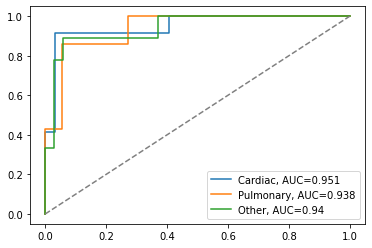

In [133]:
plt.plot(fpr_car,tpr_car,label=f"Cardiac, AUC={np.round(metrics.auc(fpr_car, tpr_car),3)}")
plt.plot(fpr_plm,tpr_plm,label=f"Pulmonary, AUC={np.round(metrics.auc(fpr_plm, tpr_plm),3)}")
plt.plot(fpr_oth,tpr_oth,label=f"Other, AUC={np.round(metrics.auc(fpr_oth, tpr_oth),3)}")
plt.plot([0,1], [0,1], color='grey', linestyle='--')
plt.legend(loc=4)
plt.show()

## Reading saved models

In [11]:
r_clf_cardiac = pickle.load(open('rest_clf_cardiac_100.sav', 'rb'))
r_scaler_100_cardiac = pickle.load(open('scaler_rest_clf_cardiac_100.sav', 'rb'))
r_clf_pulmonary_100 = pickle.load(open('rest_clf_pulmonary_100.sav', 'rb'))
r_scaler_100_pulmonary = pickle.load(open('scaler_rest_clf_pulmonary_100.sav', 'rb'))
r_clf_other_100 = pickle.load(open('rest_clf_other_100.sav', 'rb'))
r_scaler_100_other = pickle.load(open('scaler_rest_clf_other_100.sav', 'rb'))

In [12]:
rest_data_df_100

,Unnamed: 0,SessionId,PatientId,sex,age,BMI,MaxVO2_EST,MaxO2_EST,PredictedMaxHR,CardiacLim,...,75_to_100_VEVCO2Slope,75_to_100_VEVO2Slope,VTTime,SessionDuration,second_VT_Time,VO2atVT,PercentTimeAfterVT,DiffTimeAfterVT,DiffTimeAfterSecondVT,VO2vsPeakVO2atVT
0,0,7.0,7.0,F,40,35.915381,2.319521,0.010556,180.0,1,...,-0.153480,1.433403,11.0,15.5,14.5,1.206242,0.709677,4.5,4.5,0.520039
1,1,8.0,8.0,M,69,35.057157,2.657210,0.013601,159.7,1,...,1.912917,4.381880,10.5,13.5,11.5,1.239753,0.777778,3.0,3.0,0.466562
2,2,9.0,9.0,F,16,19.135218,1.444581,0.010300,196.8,0,...,1.966116,7.851560,5.5,18.5,13.0,1.707903,0.297297,13.0,13.0,1.182283
3,3,10.0,10.0,M,17,19.358400,2.293821,0.015833,196.1,0,...,0.859994,5.209331,10.5,18.5,12.0,3.049225,0.567568,8.0,8.0,1.329321
4,4,11.0,11.0,F,15,20.582507,1.933529,0.010300,197.5,0,...,2.373649,7.345030,4.5,13.5,7.5,2.299359,0.333333,9.0,9.0,1.189203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212,212,227.0,227.0,M,55,32.647091,2.664873,0.014567,169.5,0,...,-2.094273,-1.425434,0.5,7.0,-1.0,0.548573,0.071429,6.5,6.5,0.205853
213,213,228.0,228.0,M,66,30.834801,2.371165,0.013601,161.8,0,...,-0.594019,5.809173,2.0,6.5,-1.0,0.403356,0.307692,4.5,4.5,0.170109
214,214,229.0,229.0,F,65,36.729098,1.901766,0.010926,162.5,0,...,-0.337686,0.277564,4.5,14.0,10.5,0.733521,0.321429,9.5,9.5,0.385705
215,215,230.0,230.0,M,83,21.075915,1.736197,0.014300,149.9,0,...,-0.802118,1.462057,5.5,9.5,-1.0,0.568269,0.578947,4.0,4.0,0.327307


In [13]:
r_clf_cardiac

RandomForestClassifier(criterion='entropy', max_features=0.1,
                       min_samples_leaf=0.01, min_samples_split=0.01,
                       n_estimators=400, oob_score=True)

In [14]:
def interpret_model(model, data_df, features,label):
    modelLimitation = model.fit(rest_data_df_100[features],data_df[label])
    explainer = shap.TreeExplainer(modelLimitation, data=data_df[features])
    shap_values = explainer.shap_values(data_df[features])
    shap.summary_plot(shap_values[1], data_df[features], plot_type='dot', max_display=data_df.shape[1])
    pass

In [27]:
col_translated = [cardiac_feature_dict[elem] for elem in rest_cardiac_data_100[1:]]
col_translated

['Actual/Expected Peak VO2',
 'Actual - Expected Peak VO2',
 "Session's last quarter VO2 slope",
 'Minimum O2 pulse',
 "Session's last quarter HR slope",
 'Max minute ventilation',
 "Session's 85 to 15% VE Slope",
 'Last quarter VCO2 slope',
 'Second half Respiratory Rate slope',
 'Mean minute ventilation',
 'Actual - Expected maximum O2 pulse',
 'Second half VO2 slope',
 'Second half VE slope',
 'Last quarter RER slope',
 'Second half Respiratory Exchange Ratio slope',
 'VO2 at ventilatory threshold vs expected VO2',
 'Last quarter minute ventilation slope',
 'Overall mean VO2',
 'Mean O2 pulse',
 "Session's second half VO2 slope",
 "Session's first half VE/VCO2 slope"]

In [117]:
len(col_translated)

21

In [28]:
X_scaled_c = r_scaler_100_cardiac.transform(rest_data_df_100[rest_cardiac_data_100[1:]])
X_scaled_p = r_scaler_100_pulmonary.transform(rest_data_df_100[rest_pulmonary_data_100[1:]])
X_scaled_o = r_scaler_100_other.transform(rest_data_df_100[rest_other_data_100[1:]])
y_card = r_clf_cardiac.predict_proba(X_scaled_c)
y_pulm = r_clf_pulmonary_100.predict_proba(X_scaled_p)
y_other = r_clf_other_100.predict_proba(X_scaled_o)


In [32]:
kf_cardiac = KFold(n_splits=5)
X_scaled_c

array([[-0.19012434, -0.19988766,  0.92865473, ..., -0.36837991,
         0.71236475,  0.03649989],
       [-0.69321569, -0.85937756,  0.70142721, ..., -0.34994568,
         0.6120378 ,  0.06547356],
       [ 4.17843915,  2.69137096, -2.87335687, ...,  0.59753106,
        -1.51789666,  0.06412947],
       ...,
       [-0.07805706,  0.01759031,  0.83096405, ..., -0.37223663,
        -0.23435519,  0.08788353],
       [-1.13242187, -0.69934322,  0.40285001, ..., -0.36324457,
        -0.48943936,  0.02501539],
       [-0.43754424, -0.12451424,  0.48295648, ..., -0.57685227,
        -0.37743185,  0.09468683]])

In [31]:
from sklearn.model_selection import KFold

In [29]:
source_data = pd.read_csv('SourceData.csv')
source_data.head()
source_data.MainSource.drop_duplicates()

0     Duke
35     UVA
65    Book
Name: MainSource, dtype: object

In [30]:
rest_data_df_100_cp = rest_data_df_100.copy()
rest_data_df_100_cp['CardiacPred'] = y_card[:,1]
rest_data_df_100_cp['PulmPred'] = y_pulm[:,1]
rest_data_df_100_cp['OtherPred'] = y_other[:,1]
rest_data_df_100_cp = pd.merge(rest_data_df_100_cp, source_data, on='PatientId', how='left')
rest_data_df_100_cp.columns

Index(['Unnamed: 0', 'SessionId', 'PatientId', 'sex', 'age', 'BMI',
       'MaxVO2_EST', 'MaxO2_EST', 'PredictedMaxHR', 'CardiacLim',
       ...
       'VO2atVT', 'PercentTimeAfterVT', 'DiffTimeAfterVT',
       'DiffTimeAfterSecondVT', 'VO2vsPeakVO2atVT', 'CardiacPred', 'PulmPred',
       'OtherPred', 'Source', 'MainSource'],
      dtype='object', length=125)

In [198]:
duke_data = rest_data_df_100_cp.loc[rest_data_df_100_cp.MainSource == 'Duke']
book_data = rest_data_df_100_cp.loc[rest_data_df_100_cp.MainSource == 'Book']
uva_data = rest_data_df_100_cp.loc[rest_data_df_100_cp.MainSource == 'UVA']
uva_data[['CardiacLim','CardiacPred']].tail(50)

,CardiacLim,CardiacPred
56,0,0.106863
57,0,0.061442
58,0,0.020913
59,0,0.107714
60,0,0.506100
61,0,0.116126
62,0,0.132652
63,0,0.010753
177,0,0.003818
178,0,0.028312


In [203]:
print('Cardiac Evaluation: Duke vs Book vs UVA')
print('Duke',np.round(accuracy_score(duke_data.CardiacLim, np.round(duke_data.CardiacPred)),2))
print('Book',np.round(accuracy_score(book_data.CardiacLim, np.round(book_data.CardiacPred)),2))
print('UVA',np.round(accuracy_score(uva_data.CardiacLim, np.round(uva_data.CardiacPred)),2))
print('Pulmonary Evaluation: Duke vs Book vs UVA')
print('Duke',np.round(accuracy_score(duke_data.PulmonaryLim, np.round(duke_data.PulmPred)),2))
print('Book',np.round(accuracy_score(book_data.PulmonaryLim, np.round(book_data.PulmPred)),2))
print('UVA',np.round(accuracy_score(uva_data.PulmonaryLim, np.round(uva_data.PulmPred)),2))
print('Other Evaluation: Duke vs Book vs UVA')
print('Duke',np.round(accuracy_score(duke_data.MuscleSkeletalLim, np.round(duke_data.OtherPred)),2))
print('Book',np.round(accuracy_score(book_data.MuscleSkeletalLim, np.round(book_data.OtherPred)),2))
print('UVA',np.round(accuracy_score(uva_data.MuscleSkeletalLim, np.round(uva_data.OtherPred)),2))

Cardiac Evaluation: Duke vs Book vs UVA
Duke 0.94
Book 0.93
UVA 0.97
Pulmonary Evaluation: Duke vs Book vs UVA
Duke 1.0
Book 0.84
UVA 0.99
Other Evaluation: Duke vs Book vs UVA
Duke 1.0
Book 0.92
UVA 1.0


In [144]:
y_card

array([[8.33238817e-01, 1.66761183e-01],
       [5.11882937e-01, 4.88117063e-01],
       [9.59630952e-01, 4.03690476e-02],
       [9.62809524e-01, 3.71904762e-02],
       [9.65014881e-01, 3.49851190e-02],
       [9.74825397e-01, 2.51746032e-02],
       [9.85214286e-01, 1.47857143e-02],
       [9.64578193e-01, 3.54218074e-02],
       [8.00262175e-01, 1.99737825e-01],
       [9.94806548e-01, 5.19345238e-03],
       [9.95351190e-01, 4.64880952e-03],
       [9.90369048e-01, 9.63095238e-03],
       [9.04955357e-01, 9.50446429e-02],
       [9.36724026e-01, 6.32759740e-02],
       [9.89375000e-01, 1.06250000e-02],
       [9.76615079e-01, 2.33849206e-02],
       [9.95333333e-01, 4.66666667e-03],
       [9.84782738e-01, 1.52172619e-02],
       [9.49714286e-01, 5.02857143e-02],
       [9.68128968e-01, 3.18710317e-02],
       [9.95021825e-01, 4.97817460e-03],
       [9.88181548e-01, 1.18184524e-02],
       [9.40218254e-01, 5.97817460e-02],
       [9.98250000e-01, 1.75000000e-03],
       [9.901041

In [33]:
r_scaler_100_cardiac
X_scaled = r_scaler_100_cardiac.transform(rest_data_df_100[rest_cardiac_data_100[1:]])

In [34]:
X_scaled

array([[-0.19012434, -0.19988766,  0.92865473, ..., -0.36837991,
         0.71236475,  0.03649989],
       [-0.69321569, -0.85937756,  0.70142721, ..., -0.34994568,
         0.6120378 ,  0.06547356],
       [ 4.17843915,  2.69137096, -2.87335687, ...,  0.59753106,
        -1.51789666,  0.06412947],
       ...,
       [-0.07805706,  0.01759031,  0.83096405, ..., -0.37223663,
        -0.23435519,  0.08788353],
       [-1.13242187, -0.69934322,  0.40285001, ..., -0.36324457,
        -0.48943936,  0.02501539],
       [-0.43754424, -0.12451424,  0.48295648, ..., -0.57685227,
        -0.37743185,  0.09468683]])

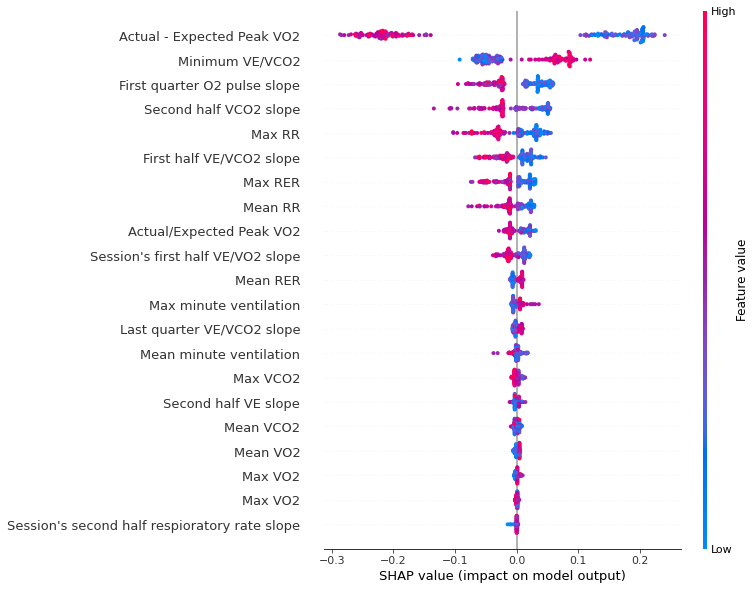

In [61]:

X_scaled_c = r_scaler_100_cardiac.transform(rest_data_df_100[rest_cardiac_data_100[1:]])
explainer_c = shap.TreeExplainer(r_clf_other_100, data=X_scaled_c,check_additivity=False)
shap_values_c = explainer_c.shap_values(X_scaled_c,check_additivity=False)
col_translated_c = [other_feature_dict[elem] for elem in rest_other_data_100[1:]]
shap.summary_plot(shap_values_c[1], X_scaled_c,feature_names=col_translated_c, plot_type='dot', max_display=data_df_100.shape[1])

In [376]:
print(r_clf_cardiac.predict_proba(X_scaled)[:,1][-1],r_clf_pulmonary_100.predict_proba(X_scaled_p)[:,1][-1],
    r_clf_other_100.predict_proba(X_scaled_o)[:,1][-1])

print(rest_data_df_100.CardiacLim.values[-1], rest_data_df_100.PulmonaryLim.values[-1], rest_data_df_100.MuscleSkeletalLim.values[-1])



0.19094336219336216 0.10576118326118326 0.5860555555555556
0 0 1


In [352]:
X_scaled = r_scaler_100_cardiac.transform(rest_data_df_100[rest_cardiac_data_100[1:]])
explainer = shap.TreeExplainer(r_clf_cardiac, data=X_scaled,check_additivity=False)
shap_values = explainer.shap_values(X_scaled)

In [ ]:
pickle.dump(shap_values[1], open(filename,'wb'))

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


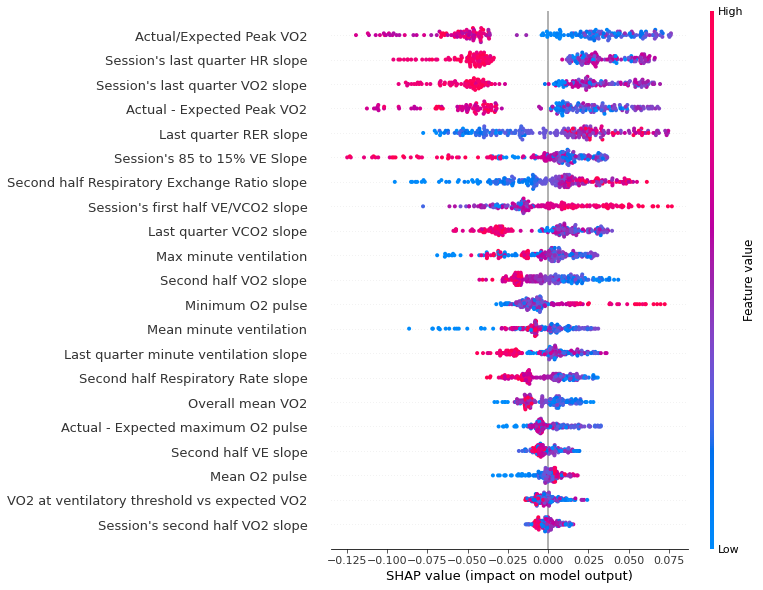

In [353]:
#shap.summary_plot(shap_values[1], X_scaled,feature_names=col_translated, plot_type='dot', max_display=data_df_100.shape[1])
shap.summary_plot(shap_values[1], X_scaled,feature_names=col_translated, plot_type='dot', max_display=data_df_100.shape[1])

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


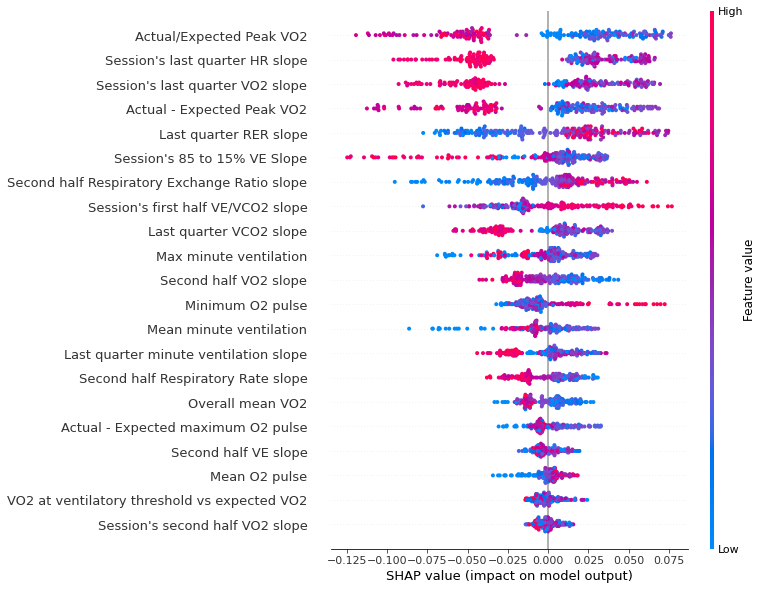

In [378]:
shap.summary_plot(shap_values[1], X_scaled,feature_names=col_translated, plot_type='dot', max_display=100)

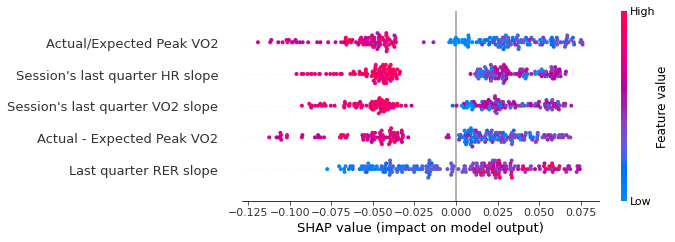

In [355]:
dfScaledC = pd.DataFrame(data=X_scaled, columns=col_translated)
shap.summary_plot(shap_values[1], dfScaledC, plot_type='dot', max_display=5)
#dfScaledC

In [ ]:
pickle.dump(shap_values[1], open(filename,'wb'))

In [309]:
import custom_shap
custom_shap.reload(summary_with_highlight)

AttributeError: module 'custom_shap' has no attribute 'reload'

In [344]:
from custom_shap import summary_with_highlight as swh

In [345]:
import importlib
importlib.reload(custom_shap)

<module 'custom_shap' from 'd:\\Projects\\CPET-BackEnd\\cpet-back-end\\custom_shap\\custom_shap.py'>

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


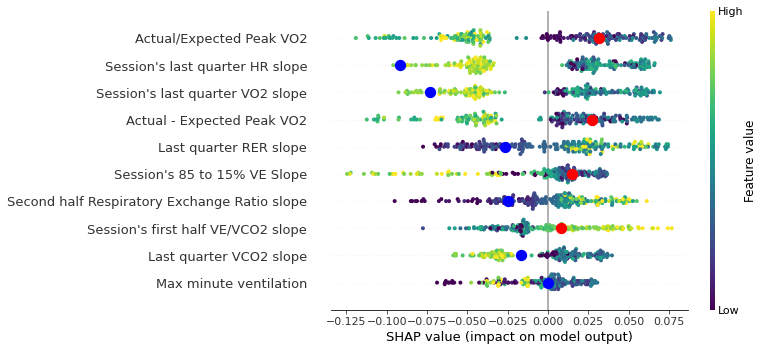

In [377]:
custom_shap.summary_with_highlight(shap_values[1],dfScaledC, row_highlight=-1, max_display=10,  cmap =plt.get_cmap('viridis'))

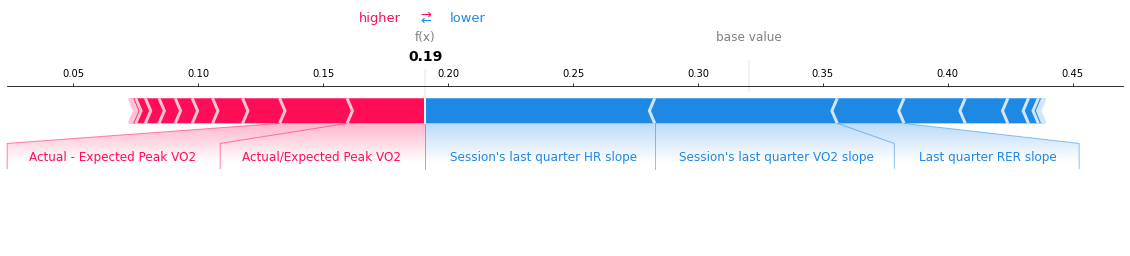

In [364]:
shap.force_plot(explainer.expected_value[1], shap_values[1][-1], feature_names=col_translated,link='identity', contribution_threshold=0.1, matplotlib=True)

In [358]:
explainer.expected_value[1]

0.32043075480075317

In [282]:
col_translated

['Actual/Expected Peak VO2',
 'Actual - Expected Peak VO2',
 "Session's last quarter VO2 slope",
 'Minimum O2 pulse',
 "Session's last quarter HR slope",
 'Max minute ventilation',
 "Session's 85 to 15% VE Slope",
 'Last quarter VCO2 slope',
 'Second half Respiratory Rate slope',
 'Mean minute ventilation',
 'Actual - Expected maximum O2 pulse',
 'Second half VO2 slope',
 'Second half VE slope',
 'Last quarter RER slope',
 'Second half Respiratory Exchange Ratio slope',
 'VO2 at ventilatory threshold vs expected VO2',
 'Last quarter minute ventilation slope',
 'Overall mean VO2',
 'Mean O2 pulse',
 "Session's second half VO2 slope",
 "Session's first half VE/VCO2 slope"]

In [281]:
rest_cardiac_data_100[1:]

['DiffPercentPeakVO2',
 'DiffPeakVO2',
 '75_to_100_VO2Slope',
 'MinO2Pulse',
 '75_to_100_HRSlope',
 'PeakVE',
 '15_to_85_VESlope',
 '75_to_100_VCO2Slope',
 'second_half_RRSlope',
 'MeanVE',
 'O2PulseDiff',
 'second_half_VO2Slope',
 'second_half_VESlope',
 '75_to_100_RERSlope',
 'second_half_RERSlope',
 'VO2vsPeakVO2atVT',
 '75_to_100_VESlope',
 'MeanVO2',
 'MeanO2Pulse',
 'second_half_VCO2Slope',
 'first_half_VEVCO2Slope']

In [279]:
X_scaled

array([[-0.19012434, -0.19988766,  0.92865473, ..., -0.36837991,
         0.71236475,  0.03649989],
       [-0.69321569, -0.85937756,  0.70142721, ..., -0.34994568,
         0.6120378 ,  0.06547356],
       [ 4.17843915,  2.69137096, -2.87335687, ...,  0.59753106,
        -1.51789666,  0.06412947],
       ...,
       [-0.07805706,  0.01759031,  0.83096405, ..., -0.37223663,
        -0.23435519,  0.08788353],
       [-1.13242187, -0.69934322,  0.40285001, ..., -0.36324457,
        -0.48943936,  0.02501539],
       [-0.43754424, -0.12451424,  0.48295648, ..., -0.57685227,
        -0.37743185,  0.09468683]])

In [ ]:
swh(shap_values[1], data_df[cardiac_top_features], row_highlight=0)

In [278]:

custom_shap.summary_with_highlight(shap_values[1], X_scaled, feature_names=col_translated, row_highlight=0, max_display=6)

TypeError: summary_with_highlight() got an unexpected keyword argument 'feature_names'

In [67]:
X_scaled.shape

(217, 21)

In [119]:
data_df_100[rest_cardiac_data_100[1:]].shape
cardiac_data_scaled = pd.DataFrame(X_scaled, columns = col_translated)

In [106]:
col_translated_c = [other_feature_dict[elem] for elem in rest_other_data_100[1:]]

In [120]:
print(len(col_translated))
col_translated

21


['Actual/Expected Peak VO2',
 'Actual - Expected Peak VO2',
 "Session's last quarter VO2 slope",
 'Minimum O2 pulse',
 "Session's last quarter HR slope",
 'Max minute ventilation',
 "Session's 85 to 15% VE Slope",
 'Last quarter VCO2 slope',
 'Second half Respiratory Rate slope',
 'Mean minute ventilation',
 'Actual - Expected maximum O2 pulse',
 'Second half VO2 slope',
 'Second half VE slope',
 'Last quarter RER slope',
 'Second half Respiratory Exchange Ratio slope',
 'VO2 at ventilatory threshold vs expected VO2',
 'Last quarter minute ventilation slope',
 'Overall mean VO2',
 'Mean O2 pulse',
 "Session's second half VO2 slope",
 "Session's first half VE/VCO2 slope"]

In [121]:
len(col_translated)
shap_values[1].shape
cardiac_data_scaled[col_translated].columns

Index(['Actual/Expected Peak VO2', 'Actual - Expected Peak VO2',
       'Session's last quarter VO2 slope', 'Minimum O2 pulse',
       'Session's last quarter HR slope', 'Max minute ventilation',
       'Session's 85 to 15% VE Slope', 'Last quarter VCO2 slope',
       'Second half Respiratory Rate slope', 'Mean minute ventilation',
       'Actual - Expected maximum O2 pulse', 'Second half VO2 slope',
       'Second half VE slope', 'Last quarter RER slope',
       'Second half Respiratory Exchange Ratio slope',
       'VO2 at ventilatory threshold vs expected VO2',
       'Last quarter minute ventilation slope', 'Overall mean VO2',
       'Mean O2 pulse', 'Session's second half VO2 slope',
       'Session's first half VE/VCO2 slope'],
      dtype='object')

In [ ]:
shap_values[1].shape
#cardiac_data_scaled[col_translated].shape
for feature in col_translated:
    shap.dependence_plot(feature, shap_values[1], cardiac_data_scaled[col_translated], show=False, interaction_index=None)

In [ ]:
ravel_plots = True
features = col_translated#rest_cardiac_data_100[1:]
if ravel_plots is True:
    for feature in features:
        shap.dependence_plot(feature, shap_values[1], cardiac_data_scaled[features], show=False, interaction_index=None)
else:
    fig, axes = plt.subplots(nrows=int(np.ceil(len(rest_cardiac_data_100[1:])/4)), ncols=4, figsize=(20, 14))
    axes = axes.ravel()
    for i, col in enumerate(features):
        shap.dependence_plot(col, shap_values[1], cardiac_data_scaled[features], ax=axes[i], show=False, interaction_index=None)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


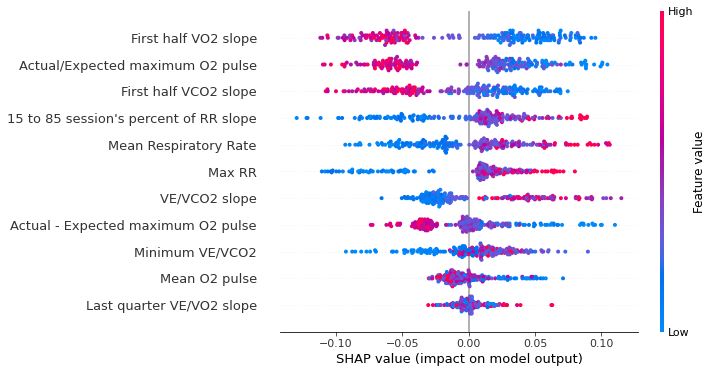

In [211]:
X_scaled_p = r_scaler_100_pulmonary.transform(rest_data_df_100[rest_pulmonary_data_100[1:]])
explainer_p = shap.TreeExplainer(r_clf_pulmonary_100, data=X_scaled_p,check_additivity=False)
shap_values_p = explainer_p.shap_values(X_scaled_p,check_additivity=False)
col_translated_p = [pulmonary_feature_dict[elem] for elem in rest_pulmonary_data_100[1:]]
shap.summary_plot(shap_values_p[1], X_scaled_p,feature_names=col_translated_p, plot_type='dot', max_display=data_df_100.shape[1])

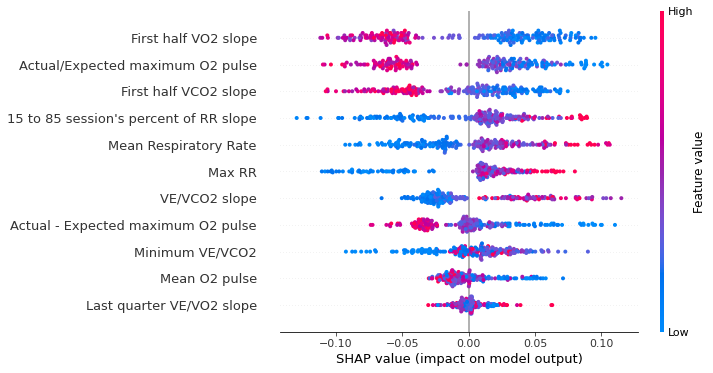

In [379]:

shap.summary_plot(shap_values_p[1], X_scaled_p,feature_names=col_translated_p, plot_type='dot', max_display=20)

In [ ]:
dfScaledC = pd.DataFrame(data=X_scaled, columns=col_translated)
shap.summary_plot(shap_values[1], dfScaledC, plot_type='dot', max_display=5)

In [332]:
pulmonary_data_scaled = pd.DataFrame(X_scaled_p, columns = col_translated_p)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


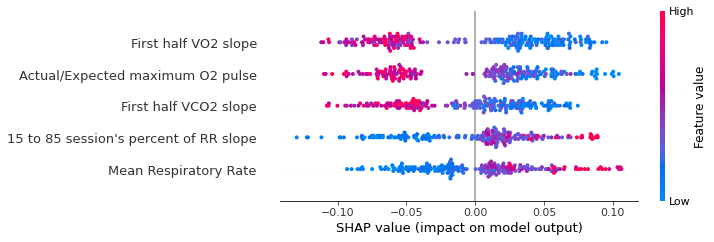

In [333]:

shap.summary_plot(shap_values_p[1], pulmonary_data_scaled, plot_type='dot', max_display=5)

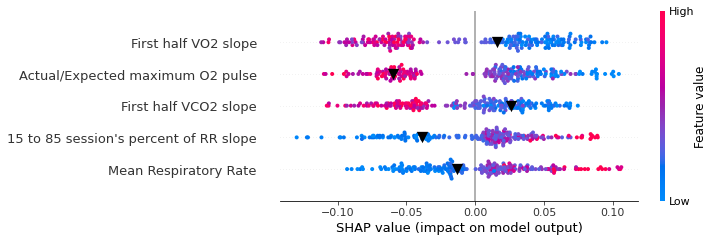

In [334]:
custom_shap.summary_with_highlight(shap_values_p[1],pulmonary_data_scaled, row_highlight=0, max_display=5)

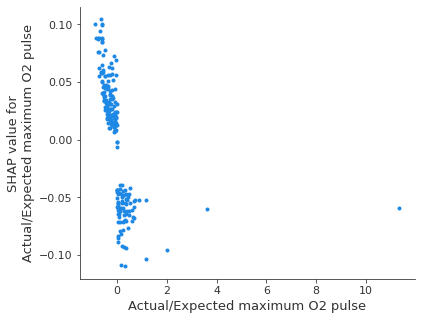

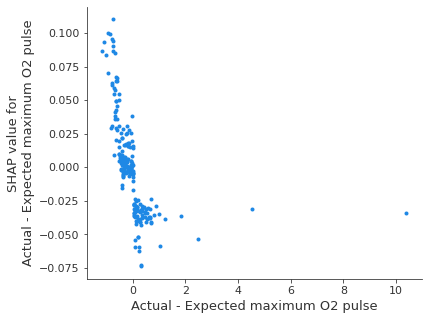

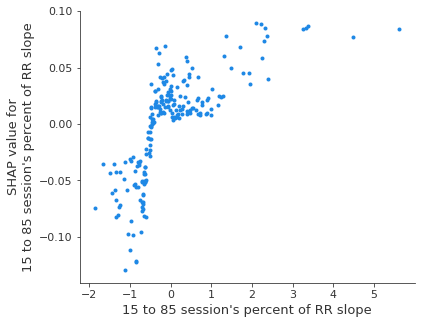

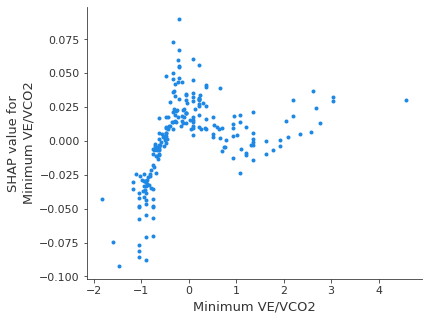

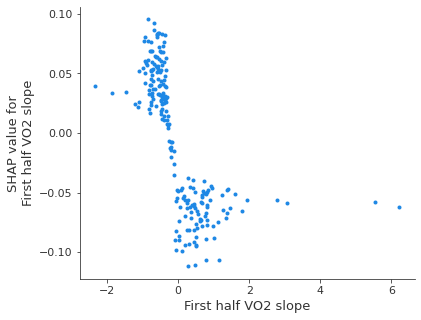

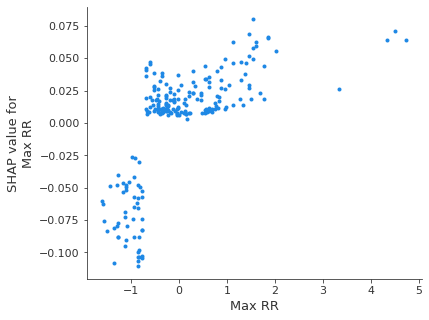

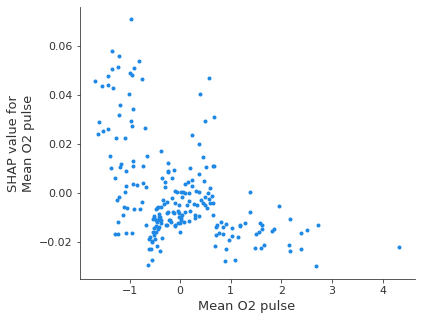

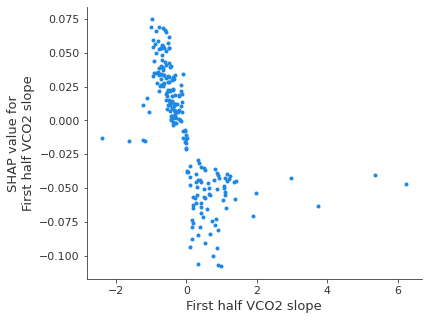

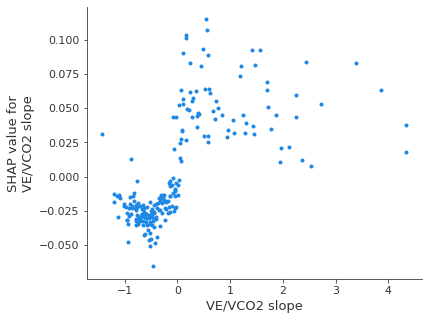

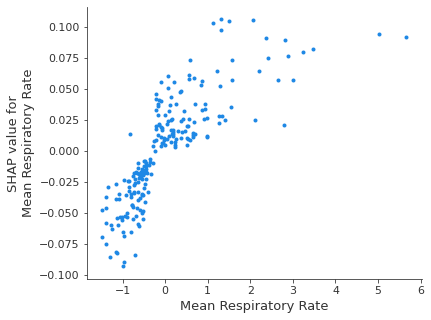

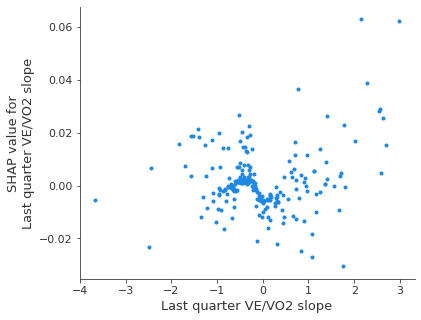

In [126]:
ravel_plots = True
features = col_translated_p#rest_cardiac_data_100[1:]
if ravel_plots is True:
    for feature in features:
        shap.dependence_plot(feature, shap_values_p[1], pulmonary_data_scaled[features], show=False, interaction_index=None)
else:
    fig, axes = plt.subplots(nrows=int(np.ceil(len(rest_cardiac_data_100[1:])/4)), ncols=4, figsize=(20, 14))
    axes = axes.ravel()
    for i, col in enumerate(features):
        shap.dependence_plot(col, shap_values_p[1], pulmonary_data_scaled[features], ax=axes[i], show=False, interaction_index=None)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


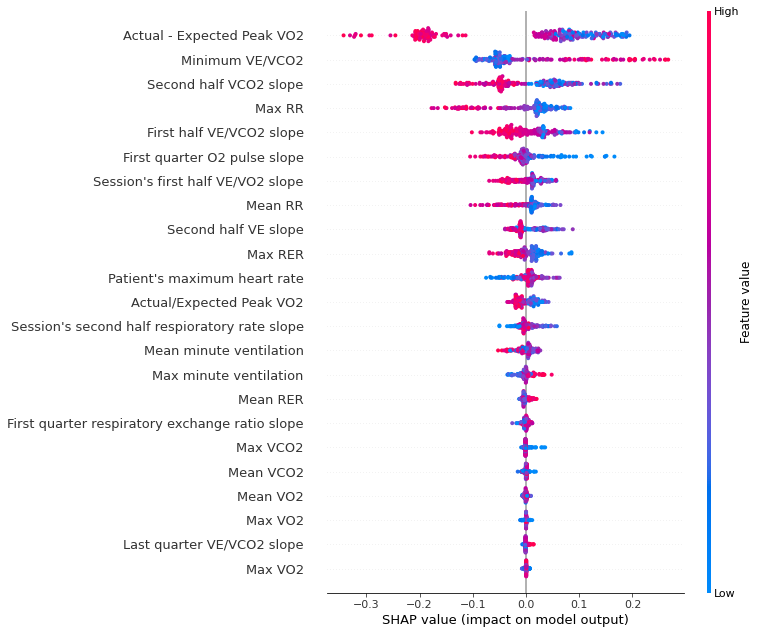

In [213]:

X_scaled_o = r_scaler_100_other.transform(rest_data_df_100[rest_other_data_100[1:]])
explainer_o = shap.TreeExplainer(r_clf_other_100, data=X_scaled_o,check_additivity=False)
shap_values_o = explainer_o.shap_values(X_scaled_o)
col_translated_o = [other_feature_dict[elem] for elem in rest_other_data_100[1:]]
shap.summary_plot(shap_values_o[1], X_scaled_o,feature_names=col_translated_o, plot_type='dot', max_display=data_df_100.shape[1])

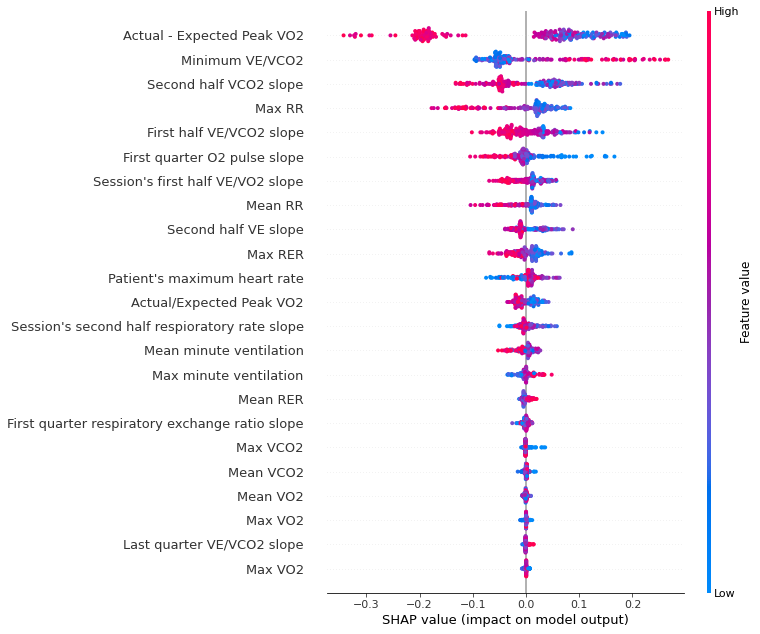

In [380]:

shap.summary_plot(shap_values_o[1], X_scaled_o,feature_names=col_translated_o, plot_type='dot', max_display=30)

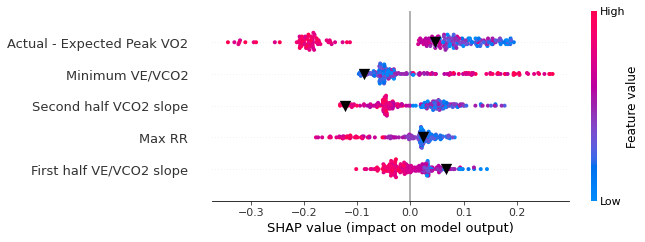

In [336]:
other_data_scaled = pd.DataFrame(X_scaled_o, columns = col_translated_o)
custom_shap.summary_with_highlight(shap_values_o[1],other_data_scaled, row_highlight=0, max_display=5)

In [267]:
shap_values_o[1]

array([[ 0.02470477, -0.00750122, -0.00092083, ..., -0.01292588,
        -0.00681399,  0.00439512],
       [ 0.03499679, -0.00306392, -0.00160234, ..., -0.00183889,
         0.00304537,  0.00762883],
       [-0.00139803,  0.00031429, -0.00097298, ...,  0.01215517,
         0.00028695,  0.01173788],
       ...,
       [ 0.03968711,  0.00764437, -0.0003748 , ...,  0.05805963,
         0.00704583,  0.00829669],
       [-0.07990167,  0.01520253,  0.00265407, ...,  0.00036037,
         0.00143447, -0.02289973],
       [ 0.0573386 , -0.01403838, -0.00096996, ..., -0.00179639,
         0.00502548, -0.01622345]])

In [128]:
other_data_scaled = pd.DataFrame(X_scaled_o, columns = col_translated_o)
other_data_scaled.shape

(217, 23)

In [417]:
pulmonary_data_scaled_filtered = pulmonary_data_scaled.loc[pulmonary_data_scaled['Actual/Expected maximum O2 pulse']<5]
pulmonary_data_scaled[pulmonary_data_scaled['Actual/Expected maximum O2 pulse']>5].index[0]

184

In [406]:
col_translated_p

['Actual/Expected maximum O2 pulse',
 'Actual - Expected maximum O2 pulse',
 "15 to 85 session's percent of RR slope",
 'Minimum VE/VCO2',
 'First half VO2 slope',
 'Max RR',
 'Mean O2 pulse',
 'First half VCO2 slope',
 'VE/VCO2 slope',
 'Mean Respiratory Rate',
 'Last quarter VE/VO2 slope']

In [420]:
pulmonary_data_scaled_filtered.shape
np.delete(shap_values_p[1], 184, axis=0).shape

(216, 11)

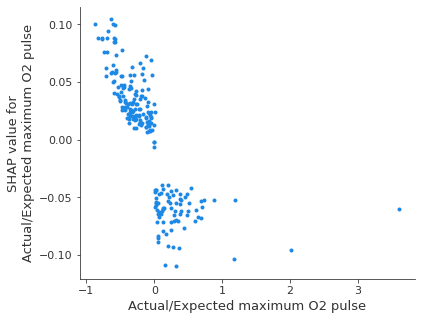

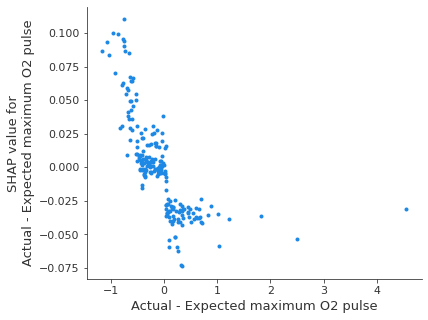

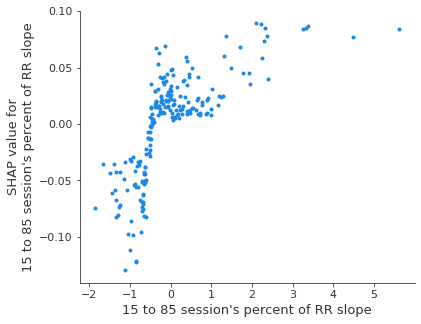

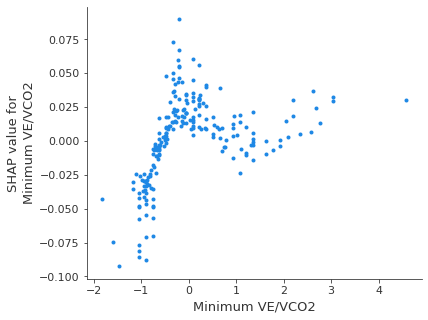

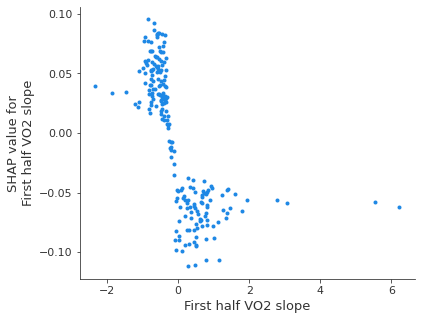

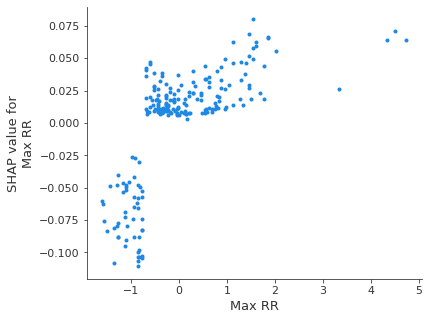

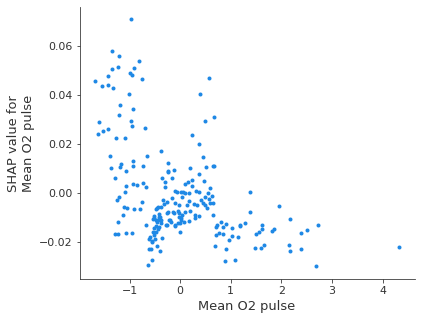

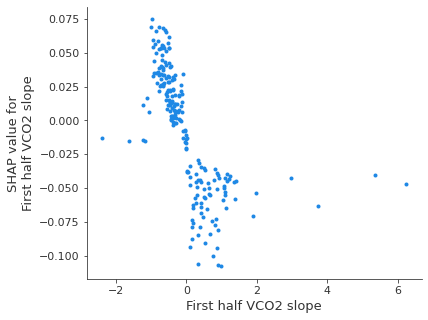

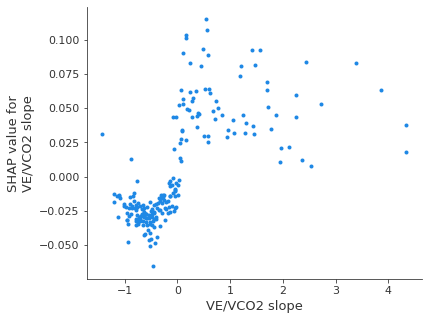

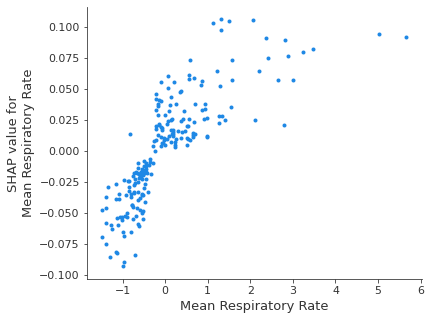

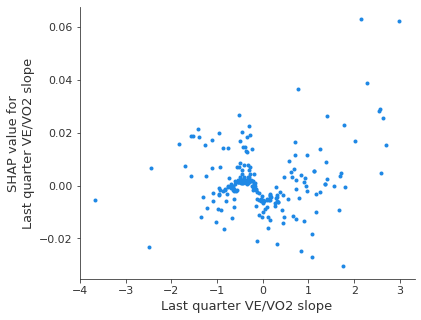

In [421]:

b = np.delete(shap_values_p[1], 184, axis=0)
ravel_plots = True
#features = other_data_scaled.columns#rest_cardiac_data_100[1:]
for feature in col_translated_p:
    shap.dependence_plot(feature, b, pulmonary_data_scaled_filtered, show=False, interaction_index=None)
    

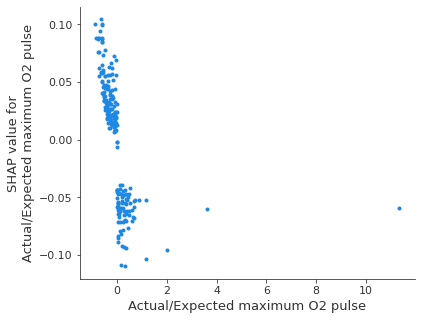

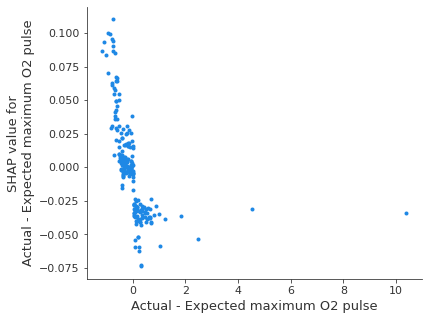

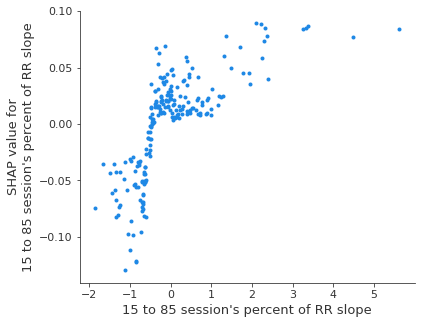

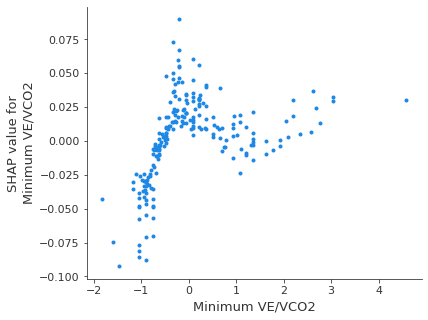

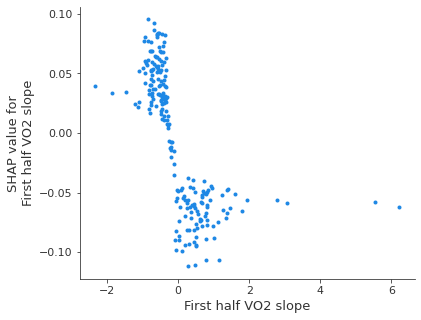

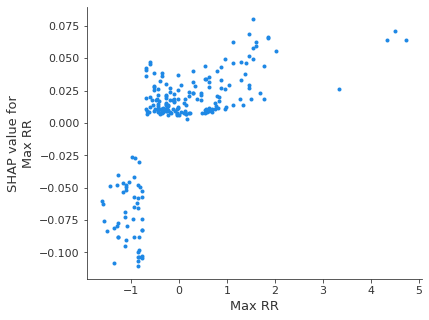

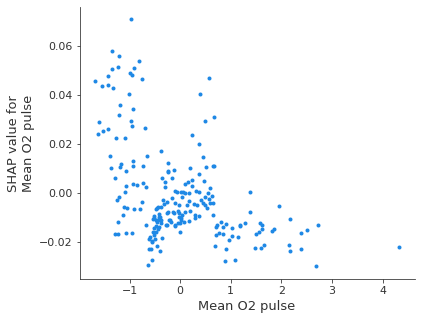

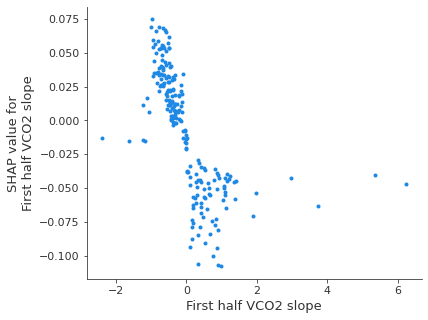

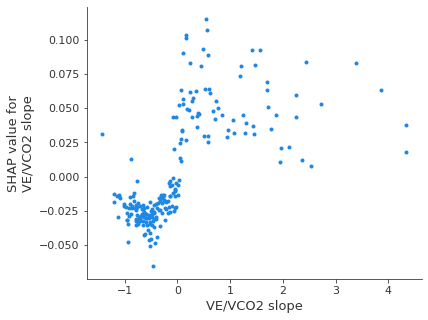

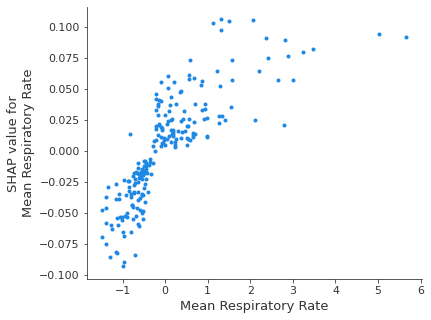

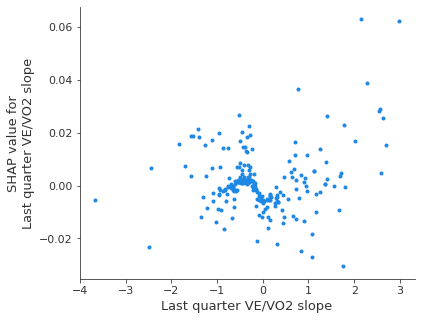

In [404]:
ravel_plots = True
features = col_translated_p#rest_cardiac_data_100[1:]
if ravel_plots is True:
    for feature in features:
        shap.dependence_plot(feature, shap_values_p[1], pulmonary_data_scaled[features], show=False, interaction_index=None)
else:
    fig, axes = plt.subplots(nrows=int(np.ceil(len(rest_cardiac_data_100[1:])/4)), ncols=4, figsize=(20, 14))
    axes = axes.ravel()
    for i, col in enumerate(features):
        shap.dependence_plot(col, shap_values_p[1], pulmonary_data_scaled[features], ax=axes[i], show=False, interaction_index=None)

In [391]:
other_data_scaled.columns

Index(['Max RR', 'Max minute ventilation', 'Max VCO2', 'Mean VCO2', 'Max VO2',
       'Max VO2', 'Last quarter VE/VCO2 slope', 'Minimum VE/VCO2',
       'Actual/Expected Peak VO2', 'Max RER', 'Mean RER',
       'Actual - Expected Peak VO2', 'Mean RR', 'Mean minute ventilation',
       'First half VE/VCO2 slope', 'Second half VE slope',
       'Session's first half VE/VO2 slope', 'Mean VO2',
       'First quarter O2 pulse slope', 'Second half VCO2 slope',
       'Session's second half respioratory rate slope',
       'First quarter respiratory exchange ratio slope',
       'Patient's maximum heart rate'],
      dtype='object')

In [400]:
other_data_scaled_filtered = other_data_scaled.loc[other_data_scaled['First half VE/VCO2 slope']>-0.2]
other_data_scaled[other_data_scaled['First half VE/VCO2 slope']<-0.2].index[0]

25

In [401]:
b = np.delete(shap_values_o[1], 25, axis=0)

In [ ]:
other_data_scaled_filtered = other_data_scaled.loc[other_data_scaled['First half VE/VCO2 slope']>-0.2]
other_data_scaled[other_data_scaled['First half VE/VCO2 slope']<-0.2].index[0]
b = np.delete(shap_values_o[1], 25, axis=0)
ravel_plots = True
features = other_data_scaled.columns#rest_cardiac_data_100[1:]
if ravel_plots is True:
    for feature in other_data_scaled.columns:
        shap.dependence_plot(feature, b, other_data_scaled_filtered, show=False, interaction_index=None)

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


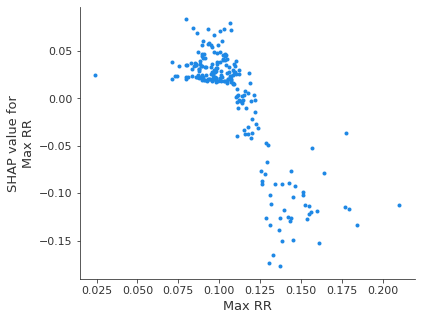

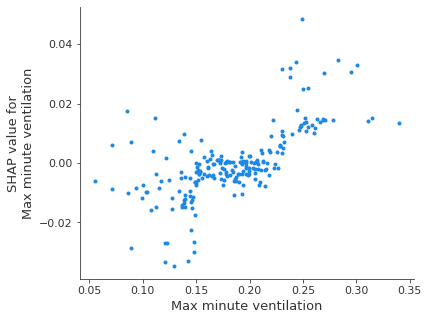

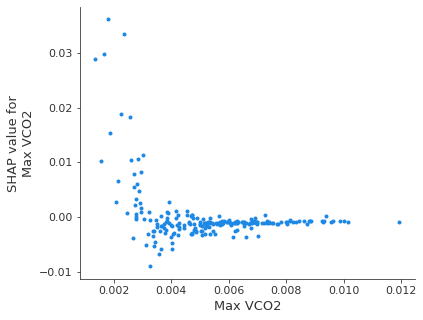

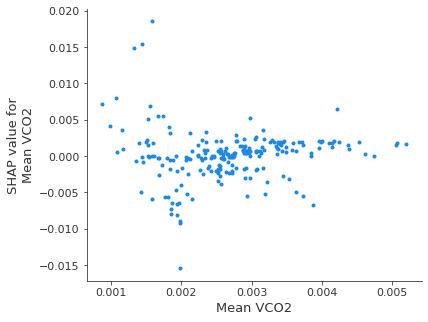

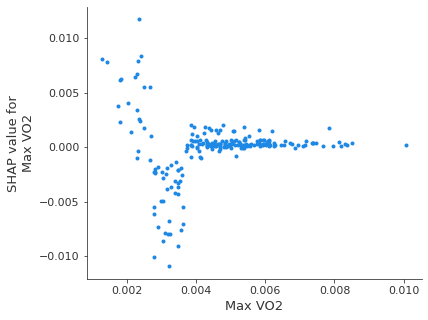

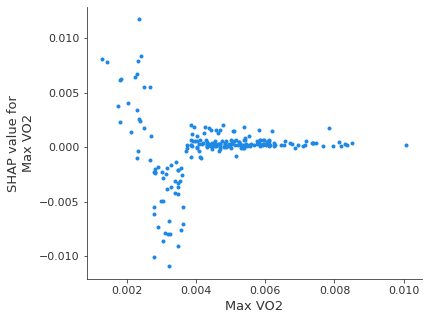

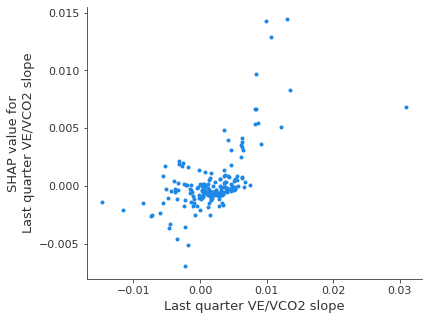

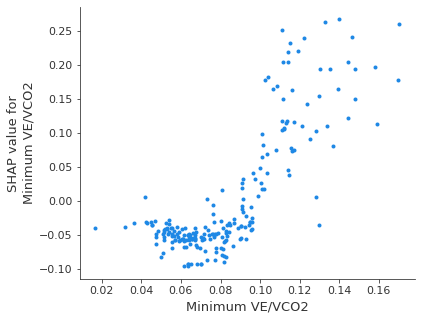

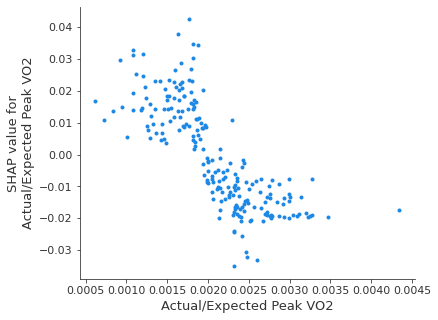

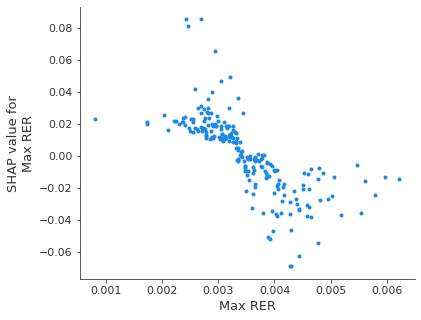

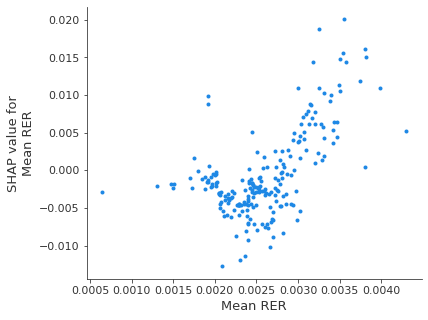

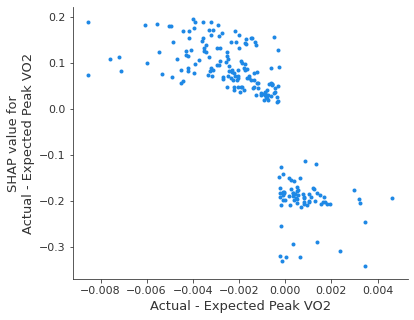

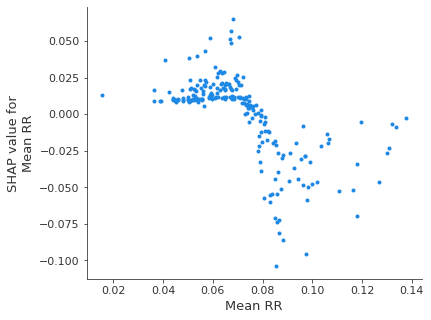

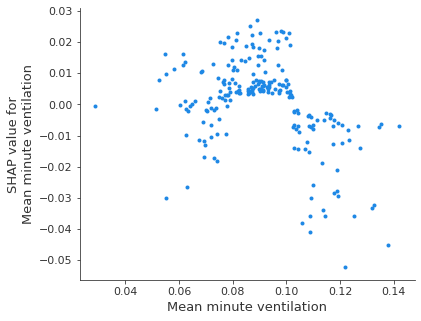

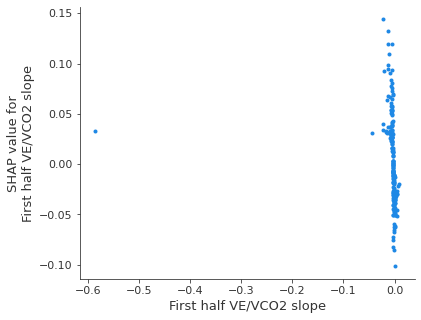

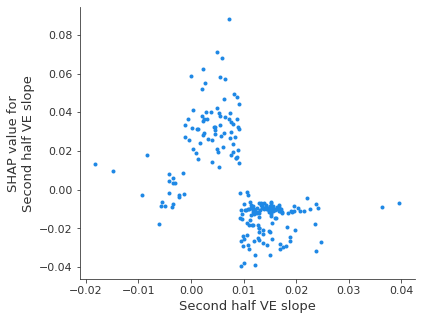

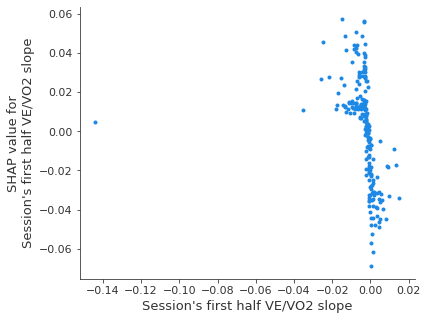

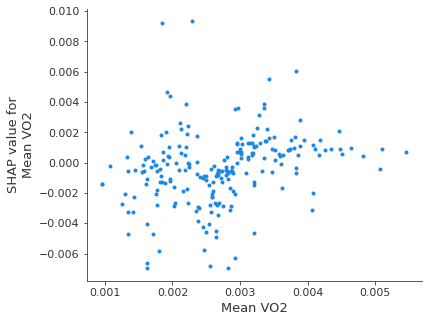

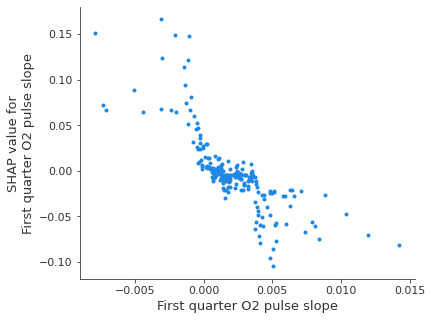

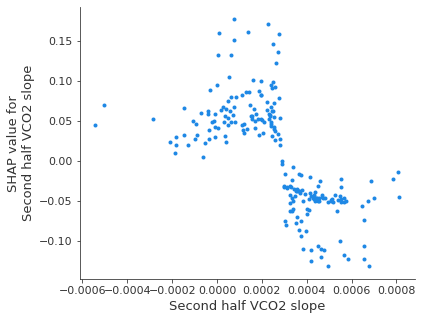

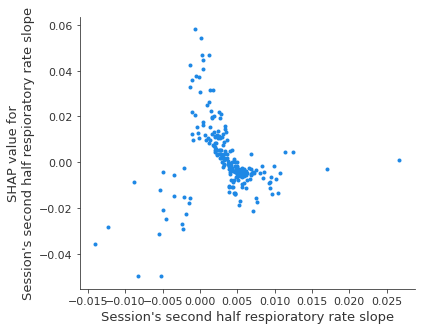

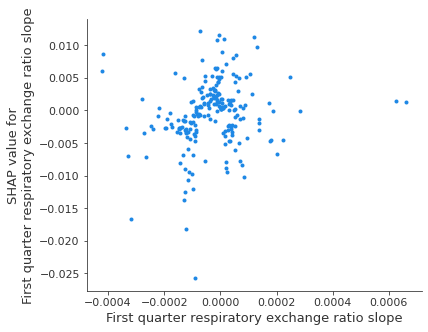

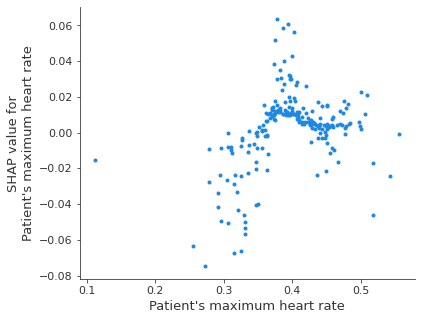

In [396]:
ravel_plots = True
features = other_data_scaled.columns#rest_cardiac_data_100[1:]
if ravel_plots is True:
    for feature in other_data_scaled.columns:
        shap.dependence_plot(feature, shap_values_o[1], other_data_scaled, show=False, interaction_index=None)

In [ ]:
X_scaled_o = r_scaler_100_other.transform(rest_data_df_100[rest_other_data_100[1:]])
other_data_scaled = pd.DataFrame(X_scaled_o, columns = col_translated)

In [ ]:

shap.summary_plot(shap_values_o[1], X_scaled_o,feature_names=col_translated_o, plot_type='dot', max_display=data_df_100.shape[1])

In [98]:
from custom_shap import summary_with_highlight as swh

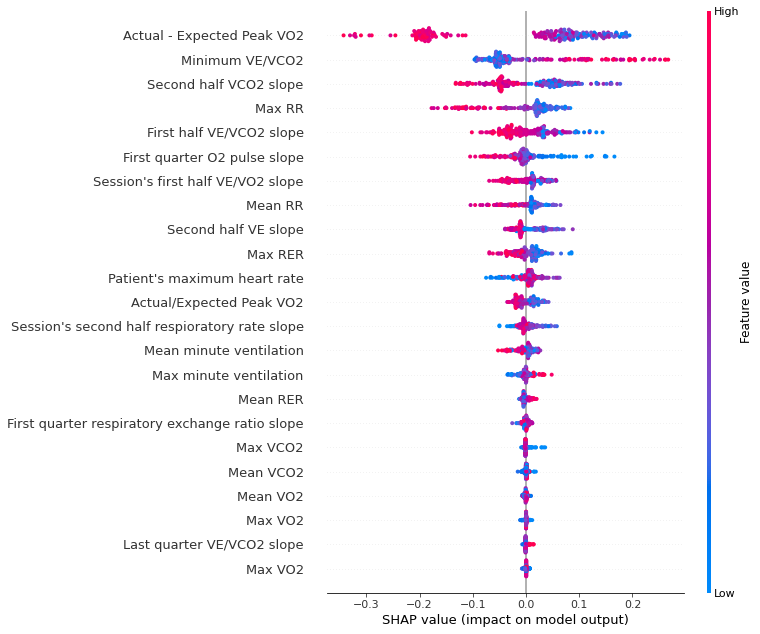

In [197]:

shap.summary_plot(shap_values_o[1], X_scaled_o,feature_names=col_translated_o, plot_type='dot', max_display=data_df_100.shape[1])
shap.summary_plot(shap_values_o[1], X_scaled_o,feature_names=col_translated_o, plot_type='dot', max_display=data_df_100.shape[1])

In [191]:
data_df_100.shape

(217, 116)

In [ ]:
X_scaled_o = r_scaler_100_other.transform(rest_data_df_100[rest_other_data_100[1:]])

In [176]:
X_scaled_o
col_translated_o

['Max RR',
 'Max minute ventilation',
 'Max VCO2',
 'Mean VCO2',
 'Max VO2',
 'Max VO2',
 'Last quarter VE/VCO2 slope',
 'Minimum VE/VCO2',
 'Actual/Expected Peak VO2',
 'Max RER',
 'Mean RER',
 'Actual - Expected Peak VO2',
 'Mean RR',
 'Mean minute ventilation',
 'First half VE/VCO2 slope',
 'Second half VE slope',
 "Session's first half VE/VO2 slope",
 'Mean VO2',
 'First quarter O2 pulse slope',
 'Second half VCO2 slope',
 "Session's second half respioratory rate slope",
 'First quarter respiratory exchange ratio slope',
 "Patient's maximum heart rate"]

In [179]:
rest_other_data_100[1:]

['PeakRR',
 'PeakVE',
 'PeakVCO2',
 'MeanVCO2',
 'PeakVO2Real',
 'PeakVO2',
 '75_to_100_VEVCO2Slope',
 'LowestVE/VCO2',
 'DiffPercentPeakVO2',
 'PeakRER',
 'MeanRER',
 'DiffPeakVO2',
 'MeanRR',
 'MeanVE',
 'first_half_VEVCO2Slope',
 'second_half_VESlope',
 'first_half_VEVO2Slope',
 'MeanVO2',
 '0_to_25_O2Slope',
 'second_half_VCO2Slope',
 'second_half_RRSlope',
 '0_to_25_RERSlope',
 'PeakHeartRate']

In [188]:
rest_other_data_100[1:]
phoenetic = [other_feature_dict[param] for param in rest_other_data_100[1:]]
other_data_scaled[col_translated_o].shape

(217, 25)

In [187]:
col_translated_o
order_list = [17, 3,  2, 21, 10,  1, 13, 20,  8, 22,  9, 15, 12, 16, 18, 14,  0, 19,  7, 11]
order_list[:] = order_list[::-1]
print(order_list)
for ordr in order_list:
    print(col_translated_o[ordr])

[11, 7, 19, 0, 14, 18, 16, 12, 15, 9, 22, 8, 20, 13, 1, 10, 21, 2, 3, 17]
Actual - Expected Peak VO2
Minimum VE/VCO2
Second half VCO2 slope
Max RR
First half VE/VCO2 slope
First quarter O2 pulse slope
Session's first half VE/VO2 slope
Mean RR
Second half VE slope
Max RER
Patient's maximum heart rate
Actual/Expected Peak VO2
Session's second half respioratory rate slope
Mean minute ventilation
Max minute ventilation
Mean RER
First quarter respiratory exchange ratio slope
Max VCO2
Mean VCO2
Mean VO2


In [207]:
import custom_shap
import imp
imp.reload(custom_shap)
#custom_shap.summary_with_highlight(shap_values_o[1], other_data_scaled[col_translated_o], row_highlight=1, max_display=data_df_100.shape[1])
custom_shap.summary_with_highlight(shap_values_o[1], X_scaled_o, feature_names=col_translated_o, row_highlight=0, max_display=data_df_100.shape[1])
#X_scaled_o,feature_names=col_translated_o, plot_type='dot', max_display=data_df_100.shape[1]

TypeError: summary_with_highlight() got an unexpected keyword argument 'feature_names'

In [84]:
X_scaled_o

array([[ 0.13194311,  0.19444435,  0.00773625, ..., -0.15960719,
         0.13854297,  0.01011023],
       [ 0.1248446 ,  0.27625394,  0.00788022, ..., -0.00763301,
         0.14694124,  0.0106996 ],
       [ 0.16202738,  0.29777248,  0.01132868, ...,  0.01184202,
         0.08914011, -0.01171018],
       ...,
       [ 0.15095322,  0.21190656,  0.00699581, ..., -0.0871629 ,
         0.13494719,  0.00762004],
       [ 0.11139045,  0.09655933,  0.00252877, ..., -0.25442389,
         0.17567338,  0.00415067],
       [ 0.1268969 ,  0.18623476,  0.00520395, ..., -0.09490729,
         0.17266902,  0.00671089]])

In [ ]:
swh(shap_values[1], data_df[cardiac_top_features], row_highlight=0)

In [79]:
from custom_shap import summary_with_highlight